<a href="https://colab.research.google.com/github/peremartra/llama-glu-expansion-pruning/blob/main/notebooks/03_Evaluate_1B_CARBON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLU Pruning Research - Llama-3.2-1B Evaluation
## 03 - Measuring Environmental Impact & Inference Performance

### Exploring energy efficiency of width-pruned GLU models
by [Pere Martra](https://github.com/peremartra)

[![Paper](https://img.shields.io/badge/OSF-Paper-blue?logo=osf&logoColor=white)](https://doi.org/10.31219/osf.io/qgxea)
[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/llama-glu-expansion-pruning](https://github.com/peremartra/llama-glu-expansion-pruning)

---

**Colab Environment:** GPU L4 (or T4)

**Models to Profile:**
- Llama-3.2-1B (baseline)
- Llama-3.2-1B-pruned-40%

**Workloads (2 representative):**
- GSM8K: Math reasoning (100 prompts, 100 max tokens)
- MMLU: Knowledge QA (100 prompts, 50 max tokens)

**Metrics Collected:**
- Energy consumption (kWh via CodeCarbon)
- Throughput (tokens/second)
- Latency (TTFT - Time To First Token)
- Memory footprint (GPU allocation)

**Estimated Runtime:** ~1-2 hours total

---

## 📋 Notebook Objective

This notebook conducts a comprehensive evaluation of the Llama-3.2-1B model family across three pruning levels (20%, 40%, 60%) to determine:

1. **Performance degradation patterns** across different pruning intensities
2. **Optimal expansion ratio** for GLU-MLP layers (hypothesis: 140%)
3. **Task-specific resilience** to pruning (knowledge vs. algorithmic tasks)
4. **Which models merit uploading to HuggingFace Hub** for Phase 2

### Key Features:
- ✅ **Checkpoint/Resume Support:** Survives Colab disconnections
- ✅ **On-the-fly Pruning:** No need to pre-create models
- ✅ **Robust Error Handling:** Continues if individual benchmarks fail
- ✅ **Progress Tracking:** Live updates and detailed logging

### Results will answer:
- Does 40% pruning (140% expansion) truly outperform other levels?
- Which benchmarks are most sensitive to pruning?
- Should we upload non-star models to HF, or only the 40% version?

---

**Note:** This evaluation uses the MAW (Maximum Absolute Weight) neuron selection method, validated in Notebook 00 as the optimal approach for GLU architectures.

---

# 1. Setup & Installation

In [1]:
# Install required libraries
!pip install -q optipfair
!pip install -q lm-eval
!pip install -q langdetect
!pip install -q codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Mount Google Drive for checkpoint persistence
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

✅ utils.py downloaded successfully


In [4]:
# Import core libraries and utilities
import torch
import json
import pandas as pd
from datetime import datetime
from pathlib import Path
import glob
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer

# Import our utility functions
from utils import (
    EXPERIMENT_CONFIG_CARBON,
    BENCHMARKS_CARBON,
    load_or_create_model,
    run_carbon_profiling,
    run_robust_evaluation,
    clear_gpu_cache,
    get_model_stats,
    format_results_table,
    calibrate_idle_power  # ← NUEVA FUNCIÓN
)

print("✅ All imports successful")
print(f"📱 Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All imports successful
📱 Device: GPU
   GPU: NVIDIA L4
   Memory: 23.8 GB


In [5]:
# =============================================================================
# EXPERIMENTAL RUNS CONFIGURATION
# =============================================================================
NUM_EXPERIMENTAL_RUNS = 3
RANDOM_SEEDS = [42, 123, 456]  # Fixed seeds for reproducibility

print(f"🔄 Experiment Configuration:")
print(f"   Number of runs: {NUM_EXPERIMENTAL_RUNS}")
print(f"   Random seeds: {RANDOM_SEEDS}")
print(f"   Total evaluations per model: {len(BENCHMARKS_CARBON)} workloads × {NUM_EXPERIMENTAL_RUNS} runs")
print()

🔄 Experiment Configuration:
   Number of runs: 3
   Random seeds: [42, 123, 456]
   Total evaluations per model: 6 workloads × 3 runs



# 2. Configuration & Planning

This section filters the experiment configuration for 1B models and displays the profiling plan.

In [6]:
# Filter configuration for 1B models only
models_1b = [
    config for config in EXPERIMENT_CONFIG_CARBON
    if "1B" in config["base_model"] and "3B" not in config["base_model"] and "Instruct" not in config["base_model"]
]

print(f"\n{'='*70}")
print("📊 EVALUATION PLAN: Llama-3.2-1B Family")
print(f"{'='*70}\n")

print(f"Total models to evaluate: {len(models_1b) + 1}")  # +1 for base model
print(f"Benchmarks per model: {len(BENCHMARKS_CARBON)}")
print(f"Total evaluations: {(len(models_1b) + 1) * len(BENCHMARKS_CARBON)}")
print(f"Estimated runtime: ~1-1.5 hours\n")

# Display models table
print("Models to profile:")
print("-" * 70)
print(f"{'Model':<40} {'Pruning':<10} {'Star':<6}")
print("-" * 70)

for config in models_1b:
    if config['pruning_pct'] == 0:
        model_name = "Llama-3.2-1B (baseline)"
    else:
        model_name = f"Llama-3.2-1B-pruned-{config['pruning_pct']}%"

    pruning = f"{config['pruning_pct']}%"
    star = "⭐ Yes" if config['is_star'] else "No"
    print(f"{model_name:<40} {pruning:<10} {star:<6}")

print("-" * 70)

# Display workloads
print("\nWorkloads to run:")
print("-" * 70)
for i, workload in enumerate(BENCHMARKS_CARBON, 1):
    name = workload['name']
    prompts = workload['num_prompts']
    tokens = workload['max_new_tokens']
    desc = workload['description']
    print(f"{i}. {name:<25} {prompts} prompts, {tokens} tokens - {desc}")
print("-" * 70)

print("\n⚙️ Configuration:")
print(f"   - Neuron selection method: MAW (Maximum Absolute Weight)")
print(f"   - Checkpointing: Enabled (per-workload granularity)")
print(f"   - Model creation: On-the-fly pruning (no pre-creation needed)")
print(f"   - GPU warm-up: First 5 prompts excluded from metrics")
print(f"   - Energy tracking: CodeCarbon")


📊 EVALUATION PLAN: Llama-3.2-1B Family

Total models to evaluate: 8
Benchmarks per model: 6
Total evaluations: 48
Estimated runtime: ~1-1.5 hours

Models to profile:
----------------------------------------------------------------------
Model                                    Pruning    Star  
----------------------------------------------------------------------
Llama-3.2-1B (baseline)                  0%         No    
Llama-3.2-1B-pruned-10%                  10%        No    
Llama-3.2-1B-pruned-20%                  20%        No    
Llama-3.2-1B-pruned-30%                  30%        No    
Llama-3.2-1B-pruned-40%                  40%        ⭐ Yes 
Llama-3.2-1B-pruned-50%                  50%        No    
Llama-3.2-1B-pruned-60%                  60%        No    
----------------------------------------------------------------------

Workloads to run:
----------------------------------------------------------------------
1. hellaswag_latency_b1      100 prompts, 20 tokens - Shor

In [7]:
# Setup checkpoint paths (manual construction since helpers are internal)
BASE_CHECKPOINT_DIR = "/content/drive/MyDrive/glu_pruning/checkpoints"
RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"

# Carbon-specific subdirectory
CHECKPOINT_DIR = f"{BASE_CHECKPOINT_DIR}/1b_carbon"

# Create directories if they don't exist
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

print(f"✅ Checkpoint directory: {CHECKPOINT_DIR}")
print(f"✅ Results directory: {RESULTS_DIR}")

# ============================================================================
# CONSTRUCT CHECKPOINT PATHS DYNAMICALLY FROM models_1b
# ============================================================================
checkpoint_paths = {}

for config in models_1b:
    pruning_pct = config['pruning_pct']

    # Create key: "baseline" for 0%, "{X}pct" for others
    if pruning_pct == 0:
        key = "baseline"
        filename = "llama_3.2_1b_baseline_carbon.json"
    else:
        key = f"{pruning_pct}pct"
        filename = f"llama_3.2_1b_pruned_{pruning_pct}pct_carbon.json"

    checkpoint_paths[key] = f"{CHECKPOINT_DIR}/{filename}"

print(f"\n📂 Auto-generated {len(checkpoint_paths)} checkpoint paths:")
for key, path in checkpoint_paths.items():
    exists = "✅ Exists" if Path(path).exists() else "🆕 New"
    print(f"  {key:<10}: {exists}")

✅ Checkpoint directory: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon
✅ Results directory: /content/drive/MyDrive/glu_pruning/results

📂 Auto-generated 7 checkpoint paths:
  baseline  : 🆕 New
  10pct     : 🆕 New
  20pct     : 🆕 New
  30pct     : 🆕 New
  40pct     : 🆕 New
  50pct     : 🆕 New
  60pct     : 🆕 New


# 3. Baseline Evaluation

Evaluate the original Llama-3.2-1B model to establish performance baseline.

In [8]:
# ====================================================================
# CALIBRATE IDLE POWER (Run once at start)
# ====================================================================
print("="*70)
print("🔋 STEP 0: IDLE POWER CALIBRATION")
print("="*70 + "\n")

idle_calibration = calibrate_idle_power(
    device="cuda",
    duration_seconds=30,  # 30s is enough for stable measurement
    verbose=True
)

# Save calibration to drive for reproducibility
calibration_path = f"{RESULTS_DIR}/idle_power_calibration.json"
with open(calibration_path, 'w') as f:
    json.dump(idle_calibration, f, indent=2)

print(f"\n💾 Calibration saved to: {calibration_path}")
print("="*70 + "\n")

🔋 STEP 0: IDLE POWER CALIBRATION

🔋 Starting idle power calibration (30s)...
   Clearing GPU cache...


[codecarbon WARNING @ 12:03:52] Multiple instances of codecarbon are allowed to run at the same time.


   Measuring idle power for 30s...
✅ Calibration complete!
   Idle Power: 31.55 W
   Idle Energy (30s): 0.000263 kWh
   GPU Temperature: 42.0°C

💾 Calibration saved to: /content/drive/MyDrive/glu_pruning/results/idle_power_calibration.json



In [9]:
print(f"\n{'='*70}")
print("📊  PHASE 1: BASELINE PROFILING")
print(f"{'='*70}\n")

BASE_MODEL_ID = "meta-llama/Llama-3.2-1B"

# ============================================================================
# MULTIPLE RUNS LOOP FOR BASELINE
# ============================================================================
baseline_all_runs = {}  # Store results from all runs

for run_idx, seed in enumerate(RANDOM_SEEDS, 1):
    print(f"\n{''*70}")
    print(f"🔄  BASELINE - RUN {run_idx}/{NUM_EXPERIMENTAL_RUNS} (seed={seed})")
    print(f"{'─'*70}\n")

    # Load base model (fresh for each run to avoid state contamination)
    print(f"Loading base model: {BASE_MODEL_ID}...")
    base_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_ID,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    print("✅  Model loaded successfully")

    # Construct checkpoint path for this run
    checkpoint_path_run = checkpoint_paths["baseline"].replace(".json", f"_run{run_idx}_seed{seed}.json")

    # Run carbon profiling with seed
    baseline_results_run = run_carbon_profiling(
        model=base_model,
        tokenizer=tokenizer,
        workloads=BENCHMARKS_CARBON,
        checkpoint_path=checkpoint_path_run,
        model_name=f"Llama-3.2-1B-baseline-run{run_idx}",
        idle_power_calibration=idle_calibration,  # ← CAMBIO: usar None
        device="cuda",
        random_seed=seed  # ← NUEVO: pasar seed
    )

    # Store results for this run
    baseline_all_runs[f"run_{run_idx}"] = baseline_results_run

    # Display run summary
    print(f"\n✅ Run {run_idx} completed")
    print("Results summary:")
    for workload_name, metrics in baseline_results_run.items():
        print(f"\n{workload_name}:")
        print(f"  Energy: {metrics['energy_kwh']:.6f} kWh")
        print(f"  Throughput: {metrics['throughput_tokens_per_sec']:.2f} tok/s")

    # Clear memory before next run
    del base_model
    clear_gpu_cache()
    print(f"🧹  Memory cleared\n")

print(f"\n{'='*70}")
print("✅  ALL BASELINE RUNS COMPLETED")
print(f"{'='*70}\n")


📊  PHASE 1: BASELINE PROFILING



🔄  BASELINE - RUN 1/3 (seed=42)
──────────────────────────────────────────────────────────────────────

Loading base model: meta-llama/Llama-3.2-1B...


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

✅  Model loaded successfully
🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_baseline_carbon_run1_seed42.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:04:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:04:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:04:37] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/24.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/6.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/6.32M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/39905 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10042 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000161 kWh
   Net emissions (idle-corrected): 0.000033 kWh
   (Idle contribution removed: 0.000127 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000033 kWh
   Throughput: 49.94 tok/s
   Avg TTFT: 100.13 ms
   Memory: 2.30 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:04:54] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:04:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:04:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:04:55] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

all/test-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

all/validation-00000-of-00001.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

all/dev-00000-of-00001.parquet:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

all/auxiliary_train-00000-of-00001.parqu(…):   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1531 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001032 kWh
   Net emissions (idle-corrected): 0.000272 kWh
   (Idle contribution removed: 0.000761 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000272 kWh
   Throughput: 51.82 tok/s
   Avg TTFT: 830.16 ms
   Memory: 2.30 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:06:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:06:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:06:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:06:23] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling


README.md: 0.00B [00:00, ?B/s]

ifeval_input_data.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/541 [00:00<?, ? examples/s]

   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000586 kWh
   Net emissions (idle-corrected): 0.000171 kWh
   (Idle contribution removed: 0.000414 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000171 kWh
   Throughput: 51.74 tok/s
   Avg TTFT: 1701.54 ms
   Memory: 2.30 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:07:11] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:07:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:07:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:07:12] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000085 kWh
   Net emissions (idle-corrected): 0.000024 kWh
   (Idle contribution removed: 0.000061 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000024 kWh
   Throughput: 240.20 tok/s
   Avg Batch Time: 484.44 ms
   Memory: 2.30 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:07:20] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:07:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:07:21] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:07:21] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000226 kWh
   Net emissions (idle-corrected): 0.000063 kWh
   (Idle contribution removed: 0.000162 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000063 kWh
   Throughput: 280.99 tok/s
   Avg Batch Time: 1358.85 ms
   Memory: 2.30 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:07:40] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:07:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:07:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:07:41] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000207 kWh
   Net emissions (idle-corrected): 0.000053 kWh
   (Idle contribution removed: 0.000153 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000053 kWh
   Throughput: 273.75 tok/s
   Avg Batch Time: 4018.31 ms
   Memory: 2.30 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 1 completed
Results summary:

hellaswag_latency_b1:
  Energy: 0.000033 kWh
  Throughput: 49.94 tok/s

mmlu_latency_b1:
  Energy: 0.000272 kWh
  Throughput: 51.82 tok/s

ifeval_latency_b1:
  Energy: 0.000171 kWh
  Throughput: 51.74 tok/s

hellaswag_throughput_b8:
  Energy: 0.000024 kWh
  Throughput: 240.20 tok/s

mmlu_throughput_b8:
  Energy: 0.000063 kWh
  Throughput: 280.99 tok/s

ifeval_throughput_b8:
  Energy: 0.00

[codecarbon WARNING @ 12:08:01] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:08:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:08:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:08:02] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000127 kWh
   Net emissions (idle-corrected): 0.000037 kWh
   (Idle contribution removed: 0.000090 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000037 kWh
   Throughput: 49.19 tok/s
   Avg TTFT: 96.50 ms
   Memory: 2.30 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:08:13] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:08:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:08:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:08:14] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000997 kWh
   Net emissions (idle-corrected): 0.000297 kWh
   (Idle contribution removed: 0.000699 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000297 kWh
   Throughput: 50.69 tok/s
   Avg TTFT: 787.65 ms
   Memory: 2.30 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:09:35] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:09:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:09:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:09:36] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000454 kWh
   Net emissions (idle-corrected): 0.000136 kWh
   (Idle contribution removed: 0.000318 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000136 kWh
   Throughput: 51.16 tok/s
   Avg TTFT: 1111.84 ms
   Memory: 2.30 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:10:13] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:10:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:10:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:10:14] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000090 kWh
   Net emissions (idle-corrected): 0.000024 kWh
   (Idle contribution removed: 0.000066 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000024 kWh
   Throughput: 248.77 tok/s
   Avg Batch Time: 485.29 ms
   Memory: 2.30 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:10:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:10:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:10:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:10:23] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000236 kWh
   Net emissions (idle-corrected): 0.000066 kWh
   (Idle contribution removed: 0.000170 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000066 kWh
   Throughput: 268.76 tok/s
   Avg Batch Time: 1420.66 ms
   Memory: 2.30 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:10:43] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:10:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:10:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:10:44] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000200 kWh
   Net emissions (idle-corrected): 0.000052 kWh
   (Idle contribution removed: 0.000148 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000052 kWh
   Throughput: 275.01 tok/s
   Avg Batch Time: 3999.85 ms
   Memory: 2.30 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 2 completed
Results summary:

hellaswag_latency_b1:
  Energy: 0.000037 kWh
  Throughput: 49.19 tok/s

mmlu_latency_b1:
  Energy: 0.000297 kWh
  Throughput: 50.69 tok/s

ifeval_latency_b1:
  Energy: 0.000136 kWh
  Throughput: 51.16 tok/s

hellaswag_throughput_b8:
  Energy: 0.000024 kWh
  Throughput: 248.77 tok/s

mmlu_throughput_b8:
  Energy: 0.000066 kWh
  Throughput: 268.76 tok/s

ifeval_throughput_b8:
  Energy: 0.0

[codecarbon WARNING @ 12:11:04] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:11:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:11:05] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:11:05] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000162 kWh
   Net emissions (idle-corrected): 0.000047 kWh
   (Idle contribution removed: 0.000114 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000047 kWh
   Throughput: 49.47 tok/s
   Avg TTFT: 121.29 ms
   Memory: 2.30 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:11:19] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:11:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:11:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:11:20] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001095 kWh
   Net emissions (idle-corrected): 0.000330 kWh
   (Idle contribution removed: 0.000764 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000330 kWh
   Throughput: 51.74 tok/s
   Avg TTFT: 855.34 ms
   Memory: 2.30 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:12:47] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:12:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:12:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:12:49] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000494 kWh
   Net emissions (idle-corrected): 0.000148 kWh
   (Idle contribution removed: 0.000346 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000148 kWh
   Throughput: 51.51 tok/s
   Avg TTFT: 1272.64 ms
   Memory: 2.30 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:13:29] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:13:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:13:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:13:30] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000090 kWh
   Net emissions (idle-corrected): 0.000024 kWh
   (Idle contribution removed: 0.000066 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000024 kWh
   Throughput: 239.87 tok/s
   Avg Batch Time: 491.18 ms
   Memory: 2.30 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:13:38] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:13:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:13:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:13:39] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000229 kWh
   Net emissions (idle-corrected): 0.000063 kWh
   (Idle contribution removed: 0.000166 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000063 kWh
   Throughput: 275.75 tok/s
   Avg Batch Time: 1384.65 ms
   Memory: 2.30 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:13:58] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:13:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:13:59] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:13:59] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000201 kWh
   Net emissions (idle-corrected): 0.000053 kWh
   (Idle contribution removed: 0.000149 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000053 kWh
   Throughput: 276.58 tok/s
   Avg Batch Time: 3977.16 ms
   Memory: 2.30 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 3 completed
Results summary:

hellaswag_latency_b1:
  Energy: 0.000047 kWh
  Throughput: 49.47 tok/s

mmlu_latency_b1:
  Energy: 0.000330 kWh
  Throughput: 51.74 tok/s

ifeval_latency_b1:
  Energy: 0.000148 kWh
  Throughput: 51.51 tok/s

hellaswag_throughput_b8:
  Energy: 0.000024 kWh
  Throughput: 239.87 tok/s

mmlu_throughput_b8:
  Energy: 0.000063 kWh
  Throughput: 275.75 tok/s

ifeval_throughput_b8:
  Energy: 0.0

# 4. Pruned Models Evaluation Loop

Profile the pruned variants using on-the-fly pruning with OptiPFair.

In [10]:
print(f"\n{'='*70}")
print("📊  PHASE 2: PRUNED MODELS PROFILING")
print(f"{'='*70}\n")

# Store all results for final comparison
# Structure: all_results[model_key][run_key] = results_dict
all_results = {
    "baseline": baseline_all_runs  # ← CAMBIO: ahora contiene múltiples runs
}

# Filter out baseline (already done)
pruned_models = [m for m in models_1b if m['pruning_pct'] > 0]

# Evaluate each pruned model
for i, config in enumerate(pruned_models, 1):
    model_name = f"Llama-3.2-1B-pruned-{config['pruning_pct']}%"
    pruning_pct = config['pruning_pct']
    is_star = config['is_star']

    print(f"\n{'─'*70}")
    print(f"🔄  PROFILING MODEL {i}/{len(pruned_models)}: {model_name}")
    print(f"   Pruning: {pruning_pct}% | Star: {'⭐ ' if is_star else '❌'}")
    print(f"{'─'*70}\n")

    # ========================================================================
    # MULTIPLE RUNS LOOP FOR THIS PRUNED MODEL
    # ========================================================================
    pruned_model_all_runs = {}

    for run_idx, seed in enumerate(RANDOM_SEEDS, 1):
        print(f"\n{'··'*35}")
        print(f"   RUN {run_idx}/{NUM_EXPERIMENTAL_RUNS} (seed={seed})")
        print(f"{'··'*35}\n")

        try:
            # Load or create model (fresh for each run)
            model, tokenizer, stats = load_or_create_model(config, device="cuda")

            # Display model statistics (once per model, not per run)
            if run_idx == 1:
                print(f"\n📈  Model Statistics:")
                print(f"   Parameters: {stats['total_parameters']:,}")
                print(f"   Size: {stats['size_gb']:.2f} GB")
                if 'pruning_stats' in stats:
                    print(f"   Reduction: {stats['pruning_stats']['percentage_reduction']:.1f}%")
                print(f"   Source: {stats['source']}\n")

            # Construct checkpoint path for this run
            checkpoint_key = f"{pruning_pct}pct"
            checkpoint_path_run = checkpoint_paths[checkpoint_key].replace(".json", f"_run{run_idx}_seed{seed}.json")

            # Run profiling with seed
            results_run = run_carbon_profiling(
                model=model,
                tokenizer=tokenizer,
                workloads=BENCHMARKS_CARBON,
                checkpoint_path=checkpoint_path_run,
                model_name=f"{model_name}-run{run_idx}",
                idle_power_calibration=idle_calibration,  # ← CAMBIO: usar None
                device="cuda",
                random_seed=seed  # ← NUEVO: pasar seed
            )

            # Store results for this run
            pruned_model_all_runs[f"run_{run_idx}"] = results_run

            print(f"\n✅ Run {run_idx} completed for {model_name}")

            # Clear memory before next run
            del model
            clear_gpu_cache()

        except Exception as e:
            print(f"\n❌  ERROR in run {run_idx}: {str(e)}")
            import traceback
            traceback.print_exc()
            clear_gpu_cache()
            continue

    # Store all runs for this model
    all_results[checkpoint_key] = pruned_model_all_runs

    print(f"\n✅ All runs completed for {model_name}\n")

print(f"\n{'='*70}")
print("✅  ALL MODELS PROFILED")
print(f"{'='*70}\n")


📊  PHASE 2: PRUNED MODELS PROFILING


──────────────────────────────────────────────────────────────────────
🔄  PROFILING MODEL 1/6: Llama-3.2-1B-pruned-10%
   Pruning: 10% | Star: ❌
──────────────────────────────────────────────────────────────────────


······································································
   RUN 1/3 (seed=42)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-10pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 10%
  Star model: No (on-the-fly)

🔧 Creating model via on-the-fly pruning...
✂️  Pruning with MAW method (10%)...


Pruning layers: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 1,155,303,424
   Reduction: 6.51%

📈  Model Statistics:
   Parameters: 1,155,303,424
   Size: 2.15 GB
   Reduction: 6.5%
   Source: on_the_fly_pruning

🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_10pct_carbon_run1_seed42.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:14:25] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:14:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:14:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:14:26] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000254 kWh
   Net emissions (idle-corrected): 0.000074 kWh
   (Idle contribution removed: 0.000180 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000074 kWh
   Throughput: 49.82 tok/s
   Avg TTFT: 194.18 ms
   Memory: 2.15 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:14:47] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:14:48] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:14:48] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:14:48] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001010 kWh
   Net emissions (idle-corrected): 0.000295 kWh
   (Idle contribution removed: 0.000715 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000295 kWh
   Throughput: 51.36 tok/s
   Avg TTFT: 816.06 ms
   Memory: 2.15 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:16:10] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:16:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:16:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:16:12] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000695 kWh
   Net emissions (idle-corrected): 0.000202 kWh
   (Idle contribution removed: 0.000493 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000202 kWh
   Throughput: 51.06 tok/s
   Avg TTFT: 2051.65 ms
   Memory: 2.15 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:17:08] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:17:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:17:09] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:17:09] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000116 kWh
   Net emissions (idle-corrected): 0.000035 kWh
   (Idle contribution removed: 0.000081 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000035 kWh
   Throughput: 239.80 tok/s
   Avg Batch Time: 636.89 ms
   Memory: 2.15 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:17:19] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:17:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:17:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:17:20] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000243 kWh
   Net emissions (idle-corrected): 0.000074 kWh
   (Idle contribution removed: 0.000168 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000074 kWh
   Throughput: 274.56 tok/s
   Avg Batch Time: 1390.65 ms
   Memory: 2.15 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:17:40] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:17:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:17:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:17:41] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000212 kWh
   Net emissions (idle-corrected): 0.000063 kWh
   (Idle contribution removed: 0.000149 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000063 kWh
   Throughput: 274.12 tok/s
   Avg Batch Time: 4012.90 ms
   Memory: 2.15 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 1 completed for Llama-3.2-1B-pruned-10%
🧹 GPU memory cleared. Available: 23.80 GB

······································································
   RUN 2/3 (seed=123)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-10pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 10%
  Star model: No (on-the-fly)

🔧 Creating model via on-the-fly pruning...
✂️ 

Pruning layers: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 1,155,303,424
   Reduction: 6.51%
🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_10pct_carbon_run2_seed123.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:18:07] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:18:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:18:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:18:08] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000204 kWh
   Net emissions (idle-corrected): 0.000058 kWh
   (Idle contribution removed: 0.000146 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000058 kWh
   Throughput: 49.77 tok/s
   Avg TTFT: 162.02 ms
   Memory: 2.15 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:18:25] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:18:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:18:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:18:26] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000926 kWh
   Net emissions (idle-corrected): 0.000273 kWh
   (Idle contribution removed: 0.000652 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000273 kWh
   Throughput: 51.27 tok/s
   Avg TTFT: 730.87 ms
   Memory: 2.15 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:19:41] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:19:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:19:42] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:19:42] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000696 kWh
   Net emissions (idle-corrected): 0.000204 kWh
   (Idle contribution removed: 0.000491 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000204 kWh
   Throughput: 51.62 tok/s
   Avg TTFT: 1811.69 ms
   Memory: 2.15 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:20:39] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:20:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:20:40] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:20:40] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000110 kWh
   Net emissions (idle-corrected): 0.000034 kWh
   (Idle contribution removed: 0.000076 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000034 kWh
   Throughput: 245.26 tok/s
   Avg Batch Time: 598.99 ms
   Memory: 2.15 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:20:49] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:20:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:20:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:20:50] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000249 kWh
   Net emissions (idle-corrected): 0.000077 kWh
   (Idle contribution removed: 0.000171 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000077 kWh
   Throughput: 269.42 tok/s
   Avg Batch Time: 1417.20 ms
   Memory: 2.15 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:21:10] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:21:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:21:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:21:12] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000209 kWh
   Net emissions (idle-corrected): 0.000062 kWh
   (Idle contribution removed: 0.000146 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000062 kWh
   Throughput: 280.05 tok/s
   Avg Batch Time: 3927.83 ms
   Memory: 2.15 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 2 completed for Llama-3.2-1B-pruned-10%
🧹 GPU memory cleared. Available: 23.80 GB

······································································
   RUN 3/3 (seed=456)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-10pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 10%
  Star model: No (on-the-fly)

🔧 Creating model via on-the-fly pruning...
✂️

Pruning layers: 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 1,155,303,424
   Reduction: 6.51%
🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_10pct_carbon_run3_seed456.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:21:37] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:21:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:21:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:21:38] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000270 kWh
   Net emissions (idle-corrected): 0.000077 kWh
   (Idle contribution removed: 0.000193 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000077 kWh
   Throughput: 50.27 tok/s
   Avg TTFT: 214.02 ms
   Memory: 2.15 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:22:00] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:22:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:22:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:22:02] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001006 kWh
   Net emissions (idle-corrected): 0.000297 kWh
   (Idle contribution removed: 0.000709 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000297 kWh
   Throughput: 51.56 tok/s
   Avg TTFT: 787.98 ms
   Memory: 2.15 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:23:23] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:23:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:23:24] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000727 kWh
   Net emissions (idle-corrected): 0.000214 kWh
   (Idle contribution removed: 0.000513 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000214 kWh
   Throughput: 51.78 tok/s
   Avg TTFT: 1861.65 ms
   Memory: 2.15 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:24:23] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:24:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:24:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:24:24] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000114 kWh
   Net emissions (idle-corrected): 0.000034 kWh
   (Idle contribution removed: 0.000080 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000034 kWh
   Throughput: 236.54 tok/s
   Avg Batch Time: 614.92 ms
   Memory: 2.15 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:24:34] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:24:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:24:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:24:35] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000244 kWh
   Net emissions (idle-corrected): 0.000075 kWh
   (Idle contribution removed: 0.000169 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000075 kWh
   Throughput: 268.69 tok/s
   Avg Batch Time: 1421.04 ms
   Memory: 2.15 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:24:55] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:24:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:24:56] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:24:56] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000212 kWh
   Net emissions (idle-corrected): 0.000063 kWh
   (Idle contribution removed: 0.000149 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000063 kWh
   Throughput: 278.15 tok/s
   Avg Batch Time: 3954.71 ms
   Memory: 2.15 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 3 completed for Llama-3.2-1B-pruned-10%
🧹 GPU memory cleared. Available: 23.80 GB

✅ All runs completed for Llama-3.2-1B-pruned-10%


──────────────────────────────────────────────────────────────────────
🔄  PROFILING MODEL 2/6: Llama-3.2-1B-pruned-20%
   Pruning: 20% | Star: ❌
──────────────────────────────────────────────────────────────────────


····································································

Pruning layers: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 1,074,792,448
   Reduction: 13.03%

📈  Model Statistics:
   Parameters: 1,074,792,448
   Size: 2.00 GB
   Reduction: 13.0%
   Source: on_the_fly_pruning

🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_20pct_carbon_run1_seed42.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:25:21] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:25:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:25:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:25:22] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000377 kWh
   Net emissions (idle-corrected): 0.000106 kWh
   (Idle contribution removed: 0.000270 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000106 kWh
   Throughput: 50.87 tok/s
   Avg TTFT: 300.48 ms
   Memory: 2.00 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:25:54] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:25:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:25:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:25:55] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000975 kWh
   Net emissions (idle-corrected): 0.000276 kWh
   (Idle contribution removed: 0.000699 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000276 kWh
   Throughput: 51.89 tok/s
   Avg TTFT: 788.17 ms
   Memory: 2.00 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:27:15] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:27:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:27:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:27:16] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000858 kWh
   Net emissions (idle-corrected): 0.000243 kWh
   (Idle contribution removed: 0.000616 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000243 kWh
   Throughput: 51.79 tok/s
   Avg TTFT: 2306.14 ms
   Memory: 2.00 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:28:27] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:28:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:28:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:28:28] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000106 kWh
   Net emissions (idle-corrected): 0.000028 kWh
   (Idle contribution removed: 0.000078 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000028 kWh
   Throughput: 252.93 tok/s
   Avg Batch Time: 603.84 ms
   Memory: 2.00 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:28:37] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:28:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:28:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:28:39] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000224 kWh
   Net emissions (idle-corrected): 0.000060 kWh
   (Idle contribution removed: 0.000164 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000060 kWh
   Throughput: 280.14 tok/s
   Avg Batch Time: 1362.98 ms
   Memory: 2.00 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:28:58] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:28:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:28:59] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:28:59] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000200 kWh
   Net emissions (idle-corrected): 0.000052 kWh
   (Idle contribution removed: 0.000148 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000052 kWh
   Throughput: 275.37 tok/s
   Avg Batch Time: 3994.68 ms
   Memory: 2.00 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 1 completed for Llama-3.2-1B-pruned-20%
🧹 GPU memory cleared. Available: 23.80 GB

······································································
   RUN 2/3 (seed=123)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-20pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 20%
  Star model: No (on-the-fly)

🔧 Creating model via on-the-fly pruning...
✂️ 

Pruning layers: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 1,074,792,448
   Reduction: 13.03%
🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_20pct_carbon_run2_seed123.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:29:24] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:29:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:29:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:29:25] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000368 kWh
   Net emissions (idle-corrected): 0.000104 kWh
   (Idle contribution removed: 0.000264 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000104 kWh
   Throughput: 50.98 tok/s
   Avg TTFT: 296.73 ms
   Memory: 2.00 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:29:55] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:29:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:29:57] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:29:57] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000929 kWh
   Net emissions (idle-corrected): 0.000257 kWh
   (Idle contribution removed: 0.000673 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000257 kWh
   Throughput: 49.80 tok/s
   Avg TTFT: 755.83 ms
   Memory: 2.00 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:31:14] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:31:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:31:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:31:15] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000896 kWh
   Net emissions (idle-corrected): 0.000251 kWh
   (Idle contribution removed: 0.000644 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000251 kWh
   Throughput: 51.53 tok/s
   Avg TTFT: 2314.86 ms
   Memory: 2.00 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:32:29] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:32:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:32:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:32:30] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000104 kWh
   Net emissions (idle-corrected): 0.000028 kWh
   (Idle contribution removed: 0.000076 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000028 kWh
   Throughput: 253.11 tok/s
   Avg Batch Time: 603.41 ms
   Memory: 2.00 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:32:39] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:32:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:32:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:32:41] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000234 kWh
   Net emissions (idle-corrected): 0.000065 kWh
   (Idle contribution removed: 0.000170 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000065 kWh
   Throughput: 270.74 tok/s
   Avg Batch Time: 1410.28 ms
   Memory: 2.00 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:33:00] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:33:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:33:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:33:02] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000201 kWh
   Net emissions (idle-corrected): 0.000051 kWh
   (Idle contribution removed: 0.000150 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000051 kWh
   Throughput: 274.71 tok/s
   Avg Batch Time: 4004.19 ms
   Memory: 2.00 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 2 completed for Llama-3.2-1B-pruned-20%
🧹 GPU memory cleared. Available: 23.80 GB

······································································
   RUN 3/3 (seed=456)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-20pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 20%
  Star model: No (on-the-fly)

🔧 Creating model via on-the-fly pruning...
✂️

Pruning layers: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 1,074,792,448
   Reduction: 13.03%
🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_20pct_carbon_run3_seed456.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:33:27] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:33:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:33:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:33:28] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000353 kWh
   Net emissions (idle-corrected): 0.000099 kWh
   (Idle contribution removed: 0.000254 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000099 kWh
   Throughput: 50.38 tok/s
   Avg TTFT: 285.21 ms
   Memory: 2.00 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:33:57] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:33:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:33:58] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:33:58] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000953 kWh
   Net emissions (idle-corrected): 0.000267 kWh
   (Idle contribution removed: 0.000686 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000267 kWh
   Throughput: 51.05 tok/s
   Avg TTFT: 764.31 ms
   Memory: 2.00 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:35:17] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:35:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:35:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:35:18] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000743 kWh
   Net emissions (idle-corrected): 0.000210 kWh
   (Idle contribution removed: 0.000533 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000210 kWh
   Throughput: 51.89 tok/s
   Avg TTFT: 1812.35 ms
   Memory: 2.00 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:36:20] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:36:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:36:21] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:36:21] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000104 kWh
   Net emissions (idle-corrected): 0.000028 kWh
   (Idle contribution removed: 0.000076 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000028 kWh
   Throughput: 253.93 tok/s
   Avg Batch Time: 601.46 ms
   Memory: 2.00 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:36:30] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:36:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:36:31] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:36:31] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000228 kWh
   Net emissions (idle-corrected): 0.000062 kWh
   (Idle contribution removed: 0.000166 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000062 kWh
   Throughput: 275.34 tok/s
   Avg Batch Time: 1386.70 ms
   Memory: 2.00 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:36:51] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:36:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:36:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:36:52] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000201 kWh
   Net emissions (idle-corrected): 0.000051 kWh
   (Idle contribution removed: 0.000149 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000051 kWh
   Throughput: 270.96 tok/s
   Avg Batch Time: 4059.58 ms
   Memory: 2.00 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 3 completed for Llama-3.2-1B-pruned-20%
🧹 GPU memory cleared. Available: 23.80 GB

✅ All runs completed for Llama-3.2-1B-pruned-20%


──────────────────────────────────────────────────────────────────────
🔄  PROFILING MODEL 3/6: Llama-3.2-1B-pruned-30%
   Pruning: 30% | Star: ❌
──────────────────────────────────────────────────────────────────────


····································································

Pruning layers: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 994,281,472
   Reduction: 19.54%

📈  Model Statistics:
   Parameters: 994,281,472
   Size: 1.85 GB
   Reduction: 19.5%
   Source: on_the_fly_pruning

🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_30pct_carbon_run1_seed42.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:37:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:37:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:37:17] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:37:17] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000478 kWh
   Net emissions (idle-corrected): 0.000131 kWh
   (Idle contribution removed: 0.000346 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000131 kWh
   Throughput: 50.90 tok/s
   Avg TTFT: 385.48 ms
   Memory: 1.85 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:37:57] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:37:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:37:58] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:37:58] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001092 kWh
   Net emissions (idle-corrected): 0.000297 kWh
   (Idle contribution removed: 0.000795 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000297 kWh
   Throughput: 50.88 tok/s
   Avg TTFT: 891.53 ms
   Memory: 1.85 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:39:30] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:39:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:39:31] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:39:31] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001009 kWh
   Net emissions (idle-corrected): 0.000275 kWh
   (Idle contribution removed: 0.000734 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000275 kWh
   Throughput: 51.61 tok/s
   Avg TTFT: 2843.42 ms
   Memory: 1.85 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:40:55] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:40:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:40:56] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:40:56] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000110 kWh
   Net emissions (idle-corrected): 0.000032 kWh
   (Idle contribution removed: 0.000078 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000032 kWh
   Throughput: 248.11 tok/s
   Avg Batch Time: 615.56 ms
   Memory: 1.85 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:41:06] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:41:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:41:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:41:07] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000234 kWh
   Net emissions (idle-corrected): 0.000069 kWh
   (Idle contribution removed: 0.000166 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000069 kWh
   Throughput: 277.12 tok/s
   Avg Batch Time: 1377.81 ms
   Memory: 1.85 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:41:26] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:41:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:41:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:41:27] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000208 kWh
   Net emissions (idle-corrected): 0.000058 kWh
   (Idle contribution removed: 0.000150 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000058 kWh
   Throughput: 274.22 tok/s
   Avg Batch Time: 4011.39 ms
   Memory: 1.85 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 1 completed for Llama-3.2-1B-pruned-30%
🧹 GPU memory cleared. Available: 23.80 GB

······································································
   RUN 2/3 (seed=123)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-30pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 30%
  Star model: No (on-the-fly)

🔧 Creating model via on-the-fly pruning...
✂️ 

Pruning layers: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 994,281,472
   Reduction: 19.54%
🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_30pct_carbon_run2_seed123.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:41:52] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:41:53] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:41:53] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:41:53] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000489 kWh
   Net emissions (idle-corrected): 0.000134 kWh
   (Idle contribution removed: 0.000356 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000134 kWh
   Throughput: 50.49 tok/s
   Avg TTFT: 396.14 ms
   Memory: 1.85 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:42:34] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:42:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:42:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:42:35] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001118 kWh
   Net emissions (idle-corrected): 0.000305 kWh
   (Idle contribution removed: 0.000813 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000305 kWh
   Throughput: 51.22 tok/s
   Avg TTFT: 923.59 ms
   Memory: 1.85 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:44:08] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:44:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:44:09] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:44:09] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000992 kWh
   Net emissions (idle-corrected): 0.000270 kWh
   (Idle contribution removed: 0.000722 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000270 kWh
   Throughput: 51.29 tok/s
   Avg TTFT: 2739.19 ms
   Memory: 1.85 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:45:32] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:45:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:45:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:45:33] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000108 kWh
   Net emissions (idle-corrected): 0.000031 kWh
   (Idle contribution removed: 0.000077 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000031 kWh
   Throughput: 250.57 tok/s
   Avg Batch Time: 609.53 ms
   Memory: 1.85 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:45:43] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:45:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:45:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:45:44] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000241 kWh
   Net emissions (idle-corrected): 0.000071 kWh
   (Idle contribution removed: 0.000170 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000071 kWh
   Throughput: 271.76 tok/s
   Avg Batch Time: 1404.98 ms
   Memory: 1.85 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:46:04] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:46:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:46:05] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:46:05] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000203 kWh
   Net emissions (idle-corrected): 0.000055 kWh
   (Idle contribution removed: 0.000148 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000055 kWh
   Throughput: 276.08 tok/s
   Avg Batch Time: 3984.39 ms
   Memory: 1.85 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 2 completed for Llama-3.2-1B-pruned-30%
🧹 GPU memory cleared. Available: 23.80 GB

······································································
   RUN 3/3 (seed=456)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-30pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 30%
  Star model: No (on-the-fly)

🔧 Creating model via on-the-fly pruning...
✂️

Pruning layers: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 994,281,472
   Reduction: 19.54%
🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_30pct_carbon_run3_seed456.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:46:29] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:46:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:46:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:46:30] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000481 kWh
   Net emissions (idle-corrected): 0.000125 kWh
   (Idle contribution removed: 0.000356 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000125 kWh
   Throughput: 50.42 tok/s
   Avg TTFT: 395.80 ms
   Memory: 1.85 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:47:11] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:47:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:47:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:47:12] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001084 kWh
   Net emissions (idle-corrected): 0.000277 kWh
   (Idle contribution removed: 0.000806 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000277 kWh
   Throughput: 50.58 tok/s
   Avg TTFT: 906.21 ms
   Memory: 1.85 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:48:45] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:48:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:48:46] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:48:46] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000867 kWh
   Net emissions (idle-corrected): 0.000220 kWh
   (Idle contribution removed: 0.000648 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000220 kWh
   Throughput: 51.30 tok/s
   Avg TTFT: 2329.82 ms
   Memory: 1.85 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:50:01] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:50:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:50:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:50:02] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000108 kWh
   Net emissions (idle-corrected): 0.000030 kWh
   (Idle contribution removed: 0.000078 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000030 kWh
   Throughput: 245.37 tok/s
   Avg Batch Time: 622.43 ms
   Memory: 1.85 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:50:11] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:50:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:50:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:50:12] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000234 kWh
   Net emissions (idle-corrected): 0.000066 kWh
   (Idle contribution removed: 0.000168 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000066 kWh
   Throughput: 271.15 tok/s
   Avg Batch Time: 1408.16 ms
   Memory: 1.85 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:50:32] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:50:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:50:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:50:33] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000201 kWh
   Net emissions (idle-corrected): 0.000053 kWh
   (Idle contribution removed: 0.000149 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000053 kWh
   Throughput: 275.01 tok/s
   Avg Batch Time: 3999.83 ms
   Memory: 1.85 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 3 completed for Llama-3.2-1B-pruned-30%
🧹 GPU memory cleared. Available: 23.80 GB

✅ All runs completed for Llama-3.2-1B-pruned-30%


──────────────────────────────────────────────────────────────────────
🔄  PROFILING MODEL 4/6: Llama-3.2-1B-pruned-40%
   Pruning: 40% | Star: ⭐ 
──────────────────────────────────────────────────────────────────────


···································································

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

✅ Loaded from HF Hub

📈  Model Statistics:
   Parameters: 913,770,496
   Size: 1.70 GB
   Source: hf_hub

🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_40pct_carbon_run1_seed42.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:50:59] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:51:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:51:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:51:00] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000468 kWh
   Net emissions (idle-corrected): 0.000112 kWh
   (Idle contribution removed: 0.000355 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000112 kWh
   Throughput: 50.68 tok/s
   Avg TTFT: 394.64 ms
   Memory: 1.70 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:51:41] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:51:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:51:42] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:51:42] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001109 kWh
   Net emissions (idle-corrected): 0.000269 kWh
   (Idle contribution removed: 0.000840 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000269 kWh
   Throughput: 51.16 tok/s
   Avg TTFT: 947.09 ms
   Memory: 1.70 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:53:18] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:53:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:53:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:53:20] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000901 kWh
   Net emissions (idle-corrected): 0.000238 kWh
   (Idle contribution removed: 0.000663 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000238 kWh
   Throughput: 51.86 tok/s
   Avg TTFT: 2520.55 ms
   Memory: 1.70 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:54:36] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:54:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:54:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:54:37] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000099 kWh
   Net emissions (idle-corrected): 0.000025 kWh
   (Idle contribution removed: 0.000074 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000025 kWh
   Throughput: 258.79 tok/s
   Avg Batch Time: 590.16 ms
   Memory: 1.70 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:54:46] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:54:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:54:47] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:54:47] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000219 kWh
   Net emissions (idle-corrected): 0.000054 kWh
   (Idle contribution removed: 0.000165 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000054 kWh
   Throughput: 277.12 tok/s
   Avg Batch Time: 1377.80 ms
   Memory: 1.70 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:55:06] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:55:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:55:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:55:08] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000201 kWh
   Net emissions (idle-corrected): 0.000047 kWh
   (Idle contribution removed: 0.000153 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000047 kWh
   Throughput: 272.28 tok/s
   Avg Batch Time: 4039.91 ms
   Memory: 1.70 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 1 completed for Llama-3.2-1B-pruned-40%
🧹 GPU memory cleared. Available: 23.80 GB

······································································
   RUN 2/3 (seed=123)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-40pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 40%
  Star model: ⭐ Yes

📥 Attempting to load from HF Hub: oopere/Llama-3.2-1B-pr

[codecarbon WARNING @ 12:55:28] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:55:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:55:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:55:29] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000489 kWh
   Net emissions (idle-corrected): 0.000130 kWh
   (Idle contribution removed: 0.000359 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000130 kWh
   Throughput: 50.05 tok/s
   Avg TTFT: 398.74 ms
   Memory: 1.70 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:56:10] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:56:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:56:11] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:56:11] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001093 kWh
   Net emissions (idle-corrected): 0.000283 kWh
   (Idle contribution removed: 0.000810 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000283 kWh
   Throughput: 50.51 tok/s
   Avg TTFT: 909.63 ms
   Memory: 1.70 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:57:44] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:57:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:57:46] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:57:46] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001051 kWh
   Net emissions (idle-corrected): 0.000274 kWh
   (Idle contribution removed: 0.000776 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000274 kWh
   Throughput: 51.41 tok/s
   Avg TTFT: 2917.82 ms
   Memory: 1.70 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:59:15] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:59:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:59:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:59:16] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000100 kWh
   Net emissions (idle-corrected): 0.000025 kWh
   (Idle contribution removed: 0.000075 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000025 kWh
   Throughput: 257.58 tok/s
   Avg Batch Time: 592.92 ms
   Memory: 1.70 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:59:25] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:59:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:59:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:59:26] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000228 kWh
   Net emissions (idle-corrected): 0.000059 kWh
   (Idle contribution removed: 0.000169 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000059 kWh
   Throughput: 272.03 tok/s
   Avg Batch Time: 1403.57 ms
   Memory: 1.70 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 12:59:46] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 12:59:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:59:47] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 12:59:47] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000196 kWh
   Net emissions (idle-corrected): 0.000045 kWh
   (Idle contribution removed: 0.000151 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000045 kWh
   Throughput: 270.30 tok/s
   Avg Batch Time: 4069.53 ms
   Memory: 1.70 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 2 completed for Llama-3.2-1B-pruned-40%
🧹 GPU memory cleared. Available: 23.80 GB

······································································
   RUN 3/3 (seed=456)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-40pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 40%
  Star model: ⭐ Yes

📥 Attempting to load from HF Hub: oopere/Llama-3.2-1B-p

[codecarbon WARNING @ 13:00:07] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:00:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:00:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:00:08] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000479 kWh
   Net emissions (idle-corrected): 0.000121 kWh
   (Idle contribution removed: 0.000359 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000121 kWh
   Throughput: 50.06 tok/s
   Avg TTFT: 399.53 ms
   Memory: 1.70 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:00:49] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:00:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:00:51] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:00:51] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001104 kWh
   Net emissions (idle-corrected): 0.000277 kWh
   (Idle contribution removed: 0.000828 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000277 kWh
   Throughput: 50.58 tok/s
   Avg TTFT: 931.58 ms
   Memory: 1.70 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:02:26] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:02:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:02:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:02:27] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000882 kWh
   Net emissions (idle-corrected): 0.000219 kWh
   (Idle contribution removed: 0.000663 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000219 kWh
   Throughput: 50.93 tok/s
   Avg TTFT: 2468.45 ms
   Memory: 1.70 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:03:43] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:03:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:03:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:03:44] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000100 kWh
   Net emissions (idle-corrected): 0.000025 kWh
   (Idle contribution removed: 0.000075 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000025 kWh
   Throughput: 257.58 tok/s
   Avg Batch Time: 592.92 ms
   Memory: 1.70 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:03:53] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:03:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:03:54] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:03:54] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000222 kWh
   Net emissions (idle-corrected): 0.000055 kWh
   (Idle contribution removed: 0.000167 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000055 kWh
   Throughput: 274.29 tok/s
   Avg Batch Time: 1392.00 ms
   Memory: 1.70 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:04:14] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:04:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:04:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:04:15] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000194 kWh
   Net emissions (idle-corrected): 0.000046 kWh
   (Idle contribution removed: 0.000148 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000046 kWh
   Throughput: 277.09 tok/s
   Avg Batch Time: 3969.85 ms
   Memory: 1.70 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 3 completed for Llama-3.2-1B-pruned-40%
🧹 GPU memory cleared. Available: 23.80 GB

✅ All runs completed for Llama-3.2-1B-pruned-40%


──────────────────────────────────────────────────────────────────────
🔄  PROFILING MODEL 5/6: Llama-3.2-1B-pruned-50%
   Pruning: 50% | Star: ❌
──────────────────────────────────────────────────────────────────────


····································································

Pruning layers: 100%|██████████| 16/16 [00:03<00:00,  4.89it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 833,161,216
   Reduction: 32.58%

📈  Model Statistics:
   Parameters: 833,161,216
   Size: 1.55 GB
   Reduction: 32.6%
   Source: on_the_fly_pruning

🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_50pct_carbon_run1_seed42.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:04:38] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 13:04:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:04:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:04:39] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000474 kWh
   Net emissions (idle-corrected): 0.000122 kWh
   (Idle contribution removed: 0.000352 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000122 kWh
   Throughput: 51.05 tok/s
   Avg TTFT: 391.76 ms
   Memory: 1.55 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:05:19] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 13:05:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:05:21] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:05:21] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001135 kWh
   Net emissions (idle-corrected): 0.000285 kWh
   (Idle contribution removed: 0.000850 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000285 kWh
   Throughput: 51.58 tok/s
   Avg TTFT: 959.43 ms
   Memory: 1.55 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:06:58] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:06:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:06:59] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:06:59] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000993 kWh
   Net emissions (idle-corrected): 0.000251 kWh
   (Idle contribution removed: 0.000742 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000251 kWh
   Throughput: 52.00 tok/s
   Avg TTFT: 2884.55 ms
   Memory: 1.55 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:08:24] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:08:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:08:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:08:26] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000098 kWh
   Net emissions (idle-corrected): 0.000023 kWh
   (Idle contribution removed: 0.000074 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000023 kWh
   Throughput: 264.39 tok/s
   Avg Batch Time: 577.65 ms
   Memory: 1.55 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:08:35] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 13:08:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:08:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:08:36] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000216 kWh
   Net emissions (idle-corrected): 0.000051 kWh
   (Idle contribution removed: 0.000165 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000051 kWh
   Throughput: 281.00 tok/s
   Avg Batch Time: 1358.79 ms
   Memory: 1.55 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:08:55] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:08:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:08:56] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:08:56] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000192 kWh
   Net emissions (idle-corrected): 0.000044 kWh
   (Idle contribution removed: 0.000148 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000044 kWh
   Throughput: 276.01 tok/s
   Avg Batch Time: 3985.43 ms
   Memory: 1.55 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 1 completed for Llama-3.2-1B-pruned-50%
🧹 GPU memory cleared. Available: 23.80 GB

······································································
   RUN 2/3 (seed=123)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-50pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 50%
  Star model: No (on-the-fly)

🔧 Creating model via on-the-fly pruning...
✂️ 

Pruning layers: 100%|██████████| 16/16 [00:03<00:00,  4.87it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 833,161,216
   Reduction: 32.58%
🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_50pct_carbon_run2_seed123.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:09:19] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 13:09:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:09:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:09:20] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000472 kWh
   Net emissions (idle-corrected): 0.000121 kWh
   (Idle contribution removed: 0.000351 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000121 kWh
   Throughput: 51.03 tok/s
   Avg TTFT: 391.94 ms
   Memory: 1.55 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:10:01] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 13:10:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:10:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:10:02] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001137 kWh
   Net emissions (idle-corrected): 0.000284 kWh
   (Idle contribution removed: 0.000852 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000284 kWh
   Throughput: 51.47 tok/s
   Avg TTFT: 961.51 ms
   Memory: 1.55 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:11:40] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:11:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:11:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:11:41] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001022 kWh
   Net emissions (idle-corrected): 0.000258 kWh
   (Idle contribution removed: 0.000764 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000258 kWh
   Throughput: 52.05 tok/s
   Avg TTFT: 2871.20 ms
   Memory: 1.55 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:13:09] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:13:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:13:10] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:13:10] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000095 kWh
   Net emissions (idle-corrected): 0.000023 kWh
   (Idle contribution removed: 0.000072 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000023 kWh
   Throughput: 272.69 tok/s
   Avg Batch Time: 560.08 ms
   Memory: 1.55 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:13:19] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:13:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:13:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:13:20] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000217 kWh
   Net emissions (idle-corrected): 0.000055 kWh
   (Idle contribution removed: 0.000163 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000055 kWh
   Throughput: 282.88 tok/s
   Avg Batch Time: 1349.78 ms
   Memory: 1.55 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:13:39] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:13:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:13:40] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:13:40] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000190 kWh
   Net emissions (idle-corrected): 0.000043 kWh
   (Idle contribution removed: 0.000147 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000043 kWh
   Throughput: 277.64 tok/s
   Avg Batch Time: 3961.92 ms
   Memory: 1.55 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 2 completed for Llama-3.2-1B-pruned-50%
🧹 GPU memory cleared. Available: 23.80 GB

······································································
   RUN 3/3 (seed=456)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-50pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 50%
  Star model: No (on-the-fly)

🔧 Creating model via on-the-fly pruning...
✂️

Pruning layers: 100%|██████████| 16/16 [00:03<00:00,  4.92it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 833,161,216
   Reduction: 32.58%
🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_50pct_carbon_run3_seed456.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:14:03] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 13:14:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:14:04] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:14:04] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000469 kWh
   Net emissions (idle-corrected): 0.000119 kWh
   (Idle contribution removed: 0.000350 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000119 kWh
   Throughput: 51.28 tok/s
   Avg TTFT: 390.00 ms
   Memory: 1.55 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:14:44] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:14:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:14:45] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:14:45] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001140 kWh
   Net emissions (idle-corrected): 0.000286 kWh
   (Idle contribution removed: 0.000854 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000286 kWh
   Throughput: 51.35 tok/s
   Avg TTFT: 963.64 ms
   Memory: 1.55 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:16:23] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 13:16:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:16:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:16:24] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000999 kWh
   Net emissions (idle-corrected): 0.000251 kWh
   (Idle contribution removed: 0.000748 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000251 kWh
   Throughput: 51.55 tok/s
   Avg TTFT: 2794.13 ms
   Memory: 1.55 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:17:50] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:17:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:17:51] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:17:51] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000096 kWh
   Net emissions (idle-corrected): 0.000023 kWh
   (Idle contribution removed: 0.000073 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000023 kWh
   Throughput: 266.39 tok/s
   Avg Batch Time: 573.32 ms
   Memory: 1.55 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:18:00] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:18:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:18:01] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:18:01] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000216 kWh
   Net emissions (idle-corrected): 0.000052 kWh
   (Idle contribution removed: 0.000164 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000052 kWh
   Throughput: 278.78 tok/s
   Avg Batch Time: 1369.60 ms
   Memory: 1.55 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:18:21] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 13:18:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:18:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:18:22] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000190 kWh
   Net emissions (idle-corrected): 0.000043 kWh
   (Idle contribution removed: 0.000148 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000043 kWh
   Throughput: 275.61 tok/s
   Avg Batch Time: 3991.22 ms
   Memory: 1.55 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 3 completed for Llama-3.2-1B-pruned-50%
🧹 GPU memory cleared. Available: 23.80 GB

✅ All runs completed for Llama-3.2-1B-pruned-50%


──────────────────────────────────────────────────────────────────────
🔄  PROFILING MODEL 6/6: Llama-3.2-1B-pruned-60%
   Pruning: 60% | Star: ❌
──────────────────────────────────────────────────────────────────────


····································································

Pruning layers: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 752,650,240
   Reduction: 39.10%

📈  Model Statistics:
   Parameters: 752,650,240
   Size: 1.40 GB
   Reduction: 39.1%
   Source: on_the_fly_pruning

🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_60pct_carbon_run1_seed42.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:18:44] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:18:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:18:45] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:18:45] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000461 kWh
   Net emissions (idle-corrected): 0.000113 kWh
   (Idle contribution removed: 0.000348 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000113 kWh
   Throughput: 51.34 tok/s
   Avg TTFT: 387.34 ms
   Memory: 1.40 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:19:26] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:19:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:19:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:19:27] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001133 kWh
   Net emissions (idle-corrected): 0.000271 kWh
   (Idle contribution removed: 0.000861 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000271 kWh
   Throughput: 51.40 tok/s
   Avg TTFT: 972.85 ms
   Memory: 1.40 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:21:06] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:21:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:21:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:21:07] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000978 kWh
   Net emissions (idle-corrected): 0.000236 kWh
   (Idle contribution removed: 0.000742 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000236 kWh
   Throughput: 51.98 tok/s
   Avg TTFT: 2885.79 ms
   Memory: 1.40 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:22:32] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:22:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:22:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:22:33] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000100 kWh
   Net emissions (idle-corrected): 0.000026 kWh
   (Idle contribution removed: 0.000074 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000026 kWh
   Throughput: 264.47 tok/s
   Avg Batch Time: 577.49 ms
   Memory: 1.40 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:22:42] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:22:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:22:43] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:22:43] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000217 kWh
   Net emissions (idle-corrected): 0.000056 kWh
   (Idle contribution removed: 0.000161 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000056 kWh
   Throughput: 283.68 tok/s
   Avg Batch Time: 1345.94 ms
   Memory: 1.40 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:23:02] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:23:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:23:03] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:23:03] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 42 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000196 kWh
   Net emissions (idle-corrected): 0.000048 kWh
   (Idle contribution removed: 0.000148 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000048 kWh
   Throughput: 273.60 tok/s
   Avg Batch Time: 4020.51 ms
   Memory: 1.40 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 1 completed for Llama-3.2-1B-pruned-60%
🧹 GPU memory cleared. Available: 23.80 GB

······································································
   RUN 2/3 (seed=123)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-60pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 60%
  Star model: No (on-the-fly)

🔧 Creating model via on-the-fly pruning...
✂️ 

Pruning layers: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 752,650,240
   Reduction: 39.10%
🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_60pct_carbon_run2_seed123.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:23:25] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:23:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:23:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:23:27] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000460 kWh
   Net emissions (idle-corrected): 0.000111 kWh
   (Idle contribution removed: 0.000349 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000111 kWh
   Throughput: 50.57 tok/s
   Avg TTFT: 387.99 ms
   Memory: 1.40 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:24:07] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:24:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:24:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:24:08] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001134 kWh
   Net emissions (idle-corrected): 0.000272 kWh
   (Idle contribution removed: 0.000862 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000272 kWh
   Throughput: 51.36 tok/s
   Avg TTFT: 973.47 ms
   Memory: 1.40 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:25:47] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:25:48] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:25:48] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:25:48] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001018 kWh
   Net emissions (idle-corrected): 0.000244 kWh
   (Idle contribution removed: 0.000774 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000244 kWh
   Throughput: 51.45 tok/s
   Avg TTFT: 2915.29 ms
   Memory: 1.40 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:27:17] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:27:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:27:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:27:18] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000099 kWh
   Net emissions (idle-corrected): 0.000025 kWh
   (Idle contribution removed: 0.000073 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000025 kWh
   Throughput: 264.23 tok/s
   Avg Batch Time: 578.00 ms
   Memory: 1.40 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:27:27] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:27:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:27:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:27:28] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000227 kWh
   Net emissions (idle-corrected): 0.000061 kWh
   (Idle contribution removed: 0.000166 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000061 kWh
   Throughput: 276.41 tok/s
   Avg Batch Time: 1381.37 ms
   Memory: 1.40 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:27:48] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:27:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:27:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:27:49] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 123 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000193 kWh
   Net emissions (idle-corrected): 0.000047 kWh
   (Idle contribution removed: 0.000146 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000047 kWh
   Throughput: 278.85 tok/s
   Avg Batch Time: 3944.79 ms
   Memory: 1.40 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 2 completed for Llama-3.2-1B-pruned-60%
🧹 GPU memory cleared. Available: 23.80 GB

······································································
   RUN 3/3 (seed=456)
······································································


Loading model: oopere/Llama-3.2-1B-pruned-60pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 60%
  Star model: No (on-the-fly)

🔧 Creating model via on-the-fly pruning...
✂️

Pruning layers: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 752,650,240
   Reduction: 39.10%
🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_60pct_carbon_run3_seed456.json
✅ Loaded checkpoint. Completed: 0/6 workloads
✅ Using idle power calibration: 31.55 W
   (Measured at: 2025-11-07T12:04:23.315788)


🚀 Starting profiling: 6 workloads remaining

[1/6] Profiling: hellaswag_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:28:11] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:28:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:28:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:28:12] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000465 kWh
   Net emissions (idle-corrected): 0.000113 kWh
   (Idle contribution removed: 0.000353 kWh)
✅ hellaswag_latency_b1 completed
   Energy: 0.000113 kWh
   Throughput: 50.66 tok/s
   Avg TTFT: 392.29 ms
   Memory: 1.40 GB

[2/6] Profiling: mmlu_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:28:53] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:28:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:28:54] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:28:54] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 100 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.001125 kWh
   Net emissions (idle-corrected): 0.000270 kWh
   (Idle contribution removed: 0.000855 kWh)
✅ mmlu_latency_b1 completed
   Energy: 0.000270 kWh
   Throughput: 51.35 tok/s
   Avg TTFT: 965.10 ms
   Memory: 1.40 GB

[3/6] Profiling: ifeval_latency_b1
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:30:32] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:30:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:30:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:30:33] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 1)
   Using 5 warmup iterations (out of 30 total)
   Running in LATENCY mode (bsz=1). Measuring TTFT...
   Tracker stopped. Raw emissions: 0.000957 kWh
   Net emissions (idle-corrected): 0.000230 kWh
   (Idle contribution removed: 0.000727 kWh)
✅ ifeval_latency_b1 completed
   Energy: 0.000230 kWh
   Throughput: 51.83 tok/s
   Avg TTFT: 2690.96 ms
   Memory: 1.40 GB

[4/6] Profiling: hellaswag_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:31:57] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:31:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:31:58] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:31:58] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from hellaswag...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000100 kWh
   Net emissions (idle-corrected): 0.000026 kWh
   (Idle contribution removed: 0.000074 kWh)
✅ hellaswag_throughput_b8 completed
   Energy: 0.000026 kWh
   Throughput: 263.34 tok/s
   Avg Batch Time: 579.96 ms
   Memory: 1.40 GB

[5/6] Profiling: mmlu_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:32:07] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:32:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:32:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:32:08] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 100 prompts from mmlu...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 2 warmup iterations (out of 13 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000222 kWh
   Net emissions (idle-corrected): 0.000059 kWh
   (Idle contribution removed: 0.000164 kWh)
✅ mmlu_throughput_b8 completed
   Energy: 0.000059 kWh
   Throughput: 279.20 tok/s
   Avg Batch Time: 1367.55 ms
   Memory: 1.40 GB

[6/6] Profiling: ifeval_throughput_b8
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 13:32:27] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB
   Running GPU warm-up for CodeCarbon sensors...


[codecarbon WARNING @ 13:32:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:32:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:32:28] No CPU tracking mode found. Falling back on CPU constant mode.


   GPU warm-up complete.
   Loading 30 prompts from IFEval...
   Using random seed: 456 for reproducible sampling
   Running inference...
   (Batch Size: 8)
   Using 1 warmup iterations (out of 4 total)
   Running in THROUGHPUT mode (bsz=8). TTFT will not be measured.
   Tracker stopped. Raw emissions: 0.000195 kWh
   Net emissions (idle-corrected): 0.000047 kWh
   (Idle contribution removed: 0.000148 kWh)
✅ ifeval_throughput_b8 completed
   Energy: 0.000047 kWh
   Throughput: 277.11 tok/s
   Avg Batch Time: 3969.59 ms
   Memory: 1.40 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Run 3 completed for Llama-3.2-1B-pruned-60%
🧹 GPU memory cleared. Available: 23.80 GB

✅ All runs completed for Llama-3.2-1B-pruned-60%


✅  ALL MODELS PROFILED



In [11]:
# ===========================================================================
# CREATE GLOBAL MAPPINGS (FOR LATER CELLS)
# ===========================================================================
# These dicts are used by cells 17, 18, and 21 for aggregation and display.

model_names = {}
model_pruning = {}
model_is_star = {}

print("\n🛠️  Creating global model mappings (model_names, model_pruning, model_is_star)...")

for config in models_1b:
    pruning_pct = config['pruning_pct']

    # Determine the key (must match Cell 10's logic: 'baseline' or '40pct')
    if pruning_pct == 0:
        key = "baseline"
        model_name = "Llama-3.2-1B (baseline)"
    else:
        key = f"{pruning_pct}pct"
        model_name = f"Llama-3.2-1B-pruned-{pruning_pct}%"

    # Populate the dictionaries
    model_names[key] = model_name
    model_pruning[key] = pruning_pct
    model_is_star[key] = config['is_star']

print(f"   ...Mappings created for {len(model_names)} models: {list(model_names.keys())}")


🛠️  Creating global model mappings (model_names, model_pruning, model_is_star)...
   ...Mappings created for 7 models: ['baseline', '10pct', '20pct', '30pct', '40pct', '50pct', '60pct']


# 5. Results Consolidation & Export

Consolidate all evaluation results and export to CSV for analysis.

In [18]:
print(f"\n{'='*70}")
print("📊  AGGREGATING RESULTS ACROSS RUNS")
print(f"{'='*70}\n")

JOULES_THRESHOLD = 0.30  # 300 mJ/token
OUTLIER_RUN_THRESHOLD = 0.3  # Si >80% de benchmarks son outliers, descartar run completo

def detect_problematic_runs(runs_dict):
    """
    Detecta runs donde la mayoría de benchmarks son outliers.
    Retorna un dict con el % de outliers por run.
    """
    run_outlier_stats = {}

    for run_key, workloads in runs_dict.items():
        outlier_count = 0
        total_count = len(workloads)

        for workload_name, data in workloads.items():
            joules = data.get('joules_per_token', 0.0)
            if joules > JOULES_THRESHOLD:
                outlier_count += 1

        outlier_percentage = outlier_count / total_count if total_count > 0 else 0
        run_outlier_stats[run_key] = {
            'outlier_count': outlier_count,
            'total_count': total_count,
            'outlier_percentage': outlier_percentage,
            'is_problematic': outlier_percentage > OUTLIER_RUN_THRESHOLD
        }

    return run_outlier_stats

def aggregate_runs(runs_dict):
    """
    Aggregate metrics from multiple runs with intelligent outlier handling.
    """
    import numpy as np

    # PASO 1: Detectar runs completamente problemáticos
    run_stats = detect_problematic_runs(runs_dict)

    print("\n    🔍 Run quality assessment:")
    for run_key, stats in run_stats.items():
        status = "❌ PROBLEMATIC" if stats['is_problematic'] else "✅ OK"
        print(f"    {run_key}: {stats['outlier_count']}/{stats['total_count']} outliers ({stats['outlier_percentage']*100:.0f}%) - {status}")

    # Filtrar runs problemáticos
    valid_runs = {k: v for k, v in runs_dict.items()
                  if not run_stats[k]['is_problematic']}
    problematic_runs = {k: v for k, v in runs_dict.items()
                       if run_stats[k]['is_problematic']}

    if not valid_runs:
        print("\n    ⚠️ WARNING: All runs are problematic. Using all runs with per-benchmark filtering.")
        valid_runs = runs_dict  # Usar todos si no hay ninguno válido
    else:
        print(f"\n    ✅ Using {len(valid_runs)}/{len(runs_dict)} runs for aggregation")
        if problematic_runs:
            print(f"    🚫 Excluding {len(problematic_runs)} problematic runs: {list(problematic_runs.keys())}")

    # PASO 2: Agregar por workload
    aggregated = {}
    outliers_log = {}

    first_valid_run_key = next((key for key, val in valid_runs.items() if val), None)
    if not first_valid_run_key:
        print("    ⚠️ Error: All runs dictionaries are empty.")
        return {}, {}, problematic_runs

    workload_names = list(valid_runs[first_valid_run_key].keys())

    for workload_name in workload_names:
        energy_samples = []
        throughput_samples = []
        ttft_samples = []
        joules_per_token_samples = []

        print(f"\n    Processing {workload_name}...")
        run_data = {}
        valid_seeds_used = []
        outliers_detected = []

        for run_key in valid_runs.keys():
            if workload_name not in valid_runs[run_key]:
                print(f"      ⚠️ Warning: '{workload_name}' missing in '{run_key}'")
                continue

            run_data_current = valid_runs[run_key][workload_name]
            joules = run_data_current.get('joules_per_token', 0.0)

            # Filtrado por benchmark
            if joules > JOULES_THRESHOLD:
                outlier_info = {
                    "run_key": run_key,
                    "joules_per_token": source_data.get('joules_per_token', 0.0),
                    "energy_kwh": run_data_current['energy_kwh'],
                    "reason": f">{JOULES_THRESHOLD:.4f} J/token"
                }
                outliers_detected.append(outlier_info)
                print(f"      🚫 Outlier: {run_key} = {joules:.4f} J/token")
            else:
                # Valor válido
                energy_samples.append(run_data_current['energy_kwh'])
                throughput_samples.append(run_data_current['throughput_tokens_per_sec'])
                joules_per_token_samples.append(joules)

                if run_data_current.get('avg_ttft_ms') is not None:
                    ttft_samples.append(run_data_current['avg_ttft_ms'])

                try:
                    run_index = int(run_key.split('_')[-1]) - 1
                    if 0 <= run_index < len(RANDOM_SEEDS):
                        valid_seeds_used.append(RANDOM_SEEDS[run_index])
                except ValueError:
                    print(f"      ⚠️ Could not parse seed from '{run_key}'")

                run_data = run_data_current

        if outliers_detected:
            outliers_log[workload_name] = outliers_detected

        # Verificar datos válidos
        if not energy_samples:
            print(f"      ❌ No valid data for {workload_name}")
            aggregated[workload_name] = {
                "error": "All measurements were outliers",
                "outliers_excluded": outliers_detected
            }
            continue

        print(f"      ✅ {len(energy_samples)} valid measurements")

        # Raw runs solo con válidos
        valid_raw_runs = {}
        for run_key in valid_runs.keys():
            if workload_name in valid_runs[run_key]:
                source_data = valid_runs[run_key][workload_name]

                valid_raw_runs[run_key] = {
                    # --- Datos existentes ---
                    "energy_kwh": source_data['energy_kwh'], # Net (actual)
                    "throughput": source_data['throughput_tokens_per_sec'],
                    "ttft_ms": source_data.get('avg_ttft_ms'),
                    "joules_per_token": source_data.get('joules_per_token', 0.0),

                    # --- NUEVOS DATOS AÑADIDOS ---
                    "energy_raw_kwh": source_data.get('energy_raw_kwh'),
                    "energy_idle_kwh": source_data.get('energy_idle_kwh'),
                    "total_new_tokens": source_data.get('total_new_tokens'),
                    "inference_duration_sec": source_data.get('hardware_metadata', {}).get('duration_sec',
                          source_data.get('total_loop_time_sec')),
                    "memory_allocated_gb": source_data.get('model_size_gb') # O 'memory_allocated_gb' si está disponible
                }

        # Calcular estadísticas
        aggregated[workload_name] = {
            "energy_kwh_mean": float(np.mean(energy_samples)),
            "energy_kwh_std": float(np.std(energy_samples, ddof=1)) if len(energy_samples) > 1 else 0.0,
            "energy_kwh_min": float(np.min(energy_samples)),
            "energy_kwh_max": float(np.max(energy_samples)),

            "throughput_mean": float(np.mean(throughput_samples)),
            "throughput_std": float(np.std(throughput_samples, ddof=1)) if len(throughput_samples) > 1 else 0.0,
            "throughput_min": float(np.min(throughput_samples)),
            "throughput_max": float(np.max(throughput_samples)),

            "ttft_mean": float(np.mean(ttft_samples)) if ttft_samples else None,
            "ttft_std": float(np.std(ttft_samples, ddof=1)) if len(ttft_samples) > 1 else None,
            "ttft_min": float(np.min(ttft_samples)) if ttft_samples else None,
            "ttft_max": float(np.max(ttft_samples)) if ttft_samples else None,

            "joules_per_token_mean": float(np.mean(joules_per_token_samples)),
            "joules_per_token_std": float(np.std(joules_per_token_samples, ddof=1)) if len(joules_per_token_samples) > 1 else 0.0,
            "joules_per_token_min": float(np.min(joules_per_token_samples)),
            "joules_per_token_max": float(np.max(joules_per_token_samples)),

            "num_runs_aggregated": len(energy_samples),
            "seeds_used": valid_seeds_used,
            "model_size_gb": run_data.get('model_size_gb', 0),
            "batch_size": run_data.get('batch_size', 0),
            "num_prompts": run_data.get('num_prompts', 0),

            "outliers_excluded": outliers_detected if outliers_detected else None,
            "outliers_count": len(outliers_detected),

            "raw_runs_data": valid_raw_runs
        }

    return aggregated, outliers_log, problematic_runs

# Aggregate results
aggregated_results = {}
all_outliers_log = {}
all_problematic_runs = {}

if 'all_results' not in globals():
    print("❌ ERROR: 'all_results' not defined.")
else:
    for model_key, runs_dict in all_results.items():
        print(f"\n{'='*70}")
        print(f"Aggregating {model_key}...")
        print(f"{'='*70}")

        aggregated, outliers_log, problematic_runs = aggregate_runs(runs_dict)
        aggregated_results[model_key] = aggregated

        if outliers_log:
            all_outliers_log[model_key] = outliers_log
        if problematic_runs:
            all_problematic_runs[model_key] = problematic_runs

    print(f"\n{'='*70}")
    print("✅ AGGREGATION COMPLETE")
    print(f"{'='*70}")
    print(f"   Models processed: {len(aggregated_results)}")
    print(f"   Total problematic runs excluded: {sum(len(v) for v in all_problematic_runs.values())}")
    print(f"   Total individual outliers: {sum(len(v) for v in all_outliers_log.values())}")

    # Reporte detallado
    if all_problematic_runs:
        print(f"\n{'='*70}")
        print("🚫 PROBLEMATIC RUNS EXCLUDED (>50% outliers)")
        print(f"{'='*70}")
        for model_key, runs in all_problematic_runs.items():
            print(f"\n{model_key}:")
            for run_key in runs.keys():
                print(f"  ❌ {run_key}")

    if all_outliers_log:
        print(f"\n{'='*70}")
        print("🚫 INDIVIDUAL OUTLIERS EXCLUDED")
        print(f"{'='*70}")
        for model_key, workloads in all_outliers_log.items():
            print(f"\n{model_key}:")
            for workload_name, outliers in workloads.items():
                print(f"  {workload_name}:")
                for outlier in outliers:
                    print(f"    - {outlier['run_key']}: {outlier['joules_per_token']:.4f} J/token")

print("\n" + "="*70 + "\n")


📊  AGGREGATING RESULTS ACROSS RUNS


Aggregating baseline...

    🔍 Run quality assessment:
    run_1: 0/6 outliers (0%) - ✅ OK
    run_2: 1/6 outliers (17%) - ✅ OK
    run_3: 1/6 outliers (17%) - ✅ OK

    ✅ Using 3/3 runs for aggregation

    Processing hellaswag_latency_b1...
      ✅ 3 valid measurements

    Processing mmlu_latency_b1...
      ✅ 3 valid measurements

    Processing ifeval_latency_b1...
      🚫 Outlier: run_2 = 0.3435 J/token
      🚫 Outlier: run_3 = 0.3254 J/token
      ✅ 1 valid measurements

    Processing hellaswag_throughput_b8...
      ✅ 3 valid measurements

    Processing mmlu_throughput_b8...
      ✅ 3 valid measurements

    Processing ifeval_throughput_b8...
      ✅ 3 valid measurements

Aggregating 10pct...

    🔍 Run quality assessment:
    run_1: 0/6 outliers (0%) - ✅ OK
    run_2: 1/6 outliers (17%) - ✅ OK
    run_3: 1/6 outliers (17%) - ✅ OK

    ✅ Using 3/3 runs for aggregation

    Processing hellaswag_latency_b1...
      ✅ 3 valid measurements

 

In [19]:
print(f"\n{'='*70}")
print("📊  CONSOLIDATING AGGREGATED RESULTS TO CSV/JSON")
print(f"{'='*70}\n")

# Build consolidated data using AGGREGATED results
consolidated_data = []

for model_key, workload_results in aggregated_results.items():
    display_name = model_names.get(model_key, model_key)
    pruning_pct = model_pruning.get(model_key, 0)
    is_star = model_is_star.get(model_key, False)

    for workload_name, metrics in workload_results.items():
        row = {
            "model": display_name,
            "pruning_pct": pruning_pct,
            "is_star": is_star,
            "workload": workload_name,

            # Aggregated metrics (mean ± std)
            "energy_kwh_mean": metrics["energy_kwh_mean"],
            "energy_kwh_std": metrics["energy_kwh_std"],
            "throughput_mean": metrics["throughput_mean"],
            "throughput_std": metrics["throughput_std"],
            "joules_per_token_mean": metrics["joules_per_token_mean"],
            "joules_per_token_std": metrics["joules_per_token_std"],
            "ttft_mean": metrics.get("ttft_mean"),
            "ttft_std": metrics.get("ttft_std"),

            # Metadata
            "num_runs": metrics["num_runs_aggregated"], # <--- LÍNEA CORREGIDA
            "model_size_gb": metrics["model_size_gb"],
            "batch_size": metrics["batch_size"],
        }
        consolidated_data.append(row)

# Create DataFrame
df = pd.DataFrame(consolidated_data)
df = df.sort_values(by=["pruning_pct", "workload"]).reset_index(drop=True)

print(f"✅  Consolidated {len(df)} result rows (with aggregated statistics)")
print(f"   Models: {df['model'].nunique()}")
print(f"   Workloads: {df['workload'].nunique()}")
# Usamos el dataframe para asegurar que contamos los runs correctos
print(f"   Runs per configuration: {df['num_runs'].max()}")

# Display preview with mean ± std
print("\nDataFrame Preview (Aggregated Results):")
print(df[['model', 'workload', 'energy_kwh_mean', 'energy_kwh_std', 'throughput_mean', 'throughput_std']].head(10))

# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"{RESULTS_DIR}/carbon_1b_aggregated_results_{timestamp}.csv"
df.to_csv(csv_path, index=False)

print(f"\n💾  Aggregated results saved to: {csv_path}")

# Also save raw runs for transparency
raw_runs_path = f"{RESULTS_DIR}/carbon_1b_raw_runs_{timestamp}.json"
with open(raw_runs_path, 'w') as f:
    json.dump(all_results, f, indent=2, default=str)  # default=str handles numpy types

print(f"💾  Raw runs data saved to: {raw_runs_path}")


📊  CONSOLIDATING AGGREGATED RESULTS TO CSV/JSON

✅  Consolidated 42 result rows (with aggregated statistics)
   Models: 7
   Workloads: 6
   Runs per configuration: 3

DataFrame Preview (Aggregated Results):
                     model                 workload  energy_kwh_mean  \
0  Llama-3.2-1B (baseline)     hellaswag_latency_b1         0.000039   
1  Llama-3.2-1B (baseline)  hellaswag_throughput_b8         0.000024   
2  Llama-3.2-1B (baseline)        ifeval_latency_b1         0.000171   
3  Llama-3.2-1B (baseline)     ifeval_throughput_b8         0.000053   
4  Llama-3.2-1B (baseline)          mmlu_latency_b1         0.000300   
5  Llama-3.2-1B (baseline)       mmlu_throughput_b8         0.000064   
6  Llama-3.2-1B-pruned-10%     hellaswag_latency_b1         0.000070   
7  Llama-3.2-1B-pruned-10%  hellaswag_throughput_b8         0.000034   
8  Llama-3.2-1B-pruned-10%        ifeval_latency_b1         0.000202   
9  Llama-3.2-1B-pruned-10%     ifeval_throughput_b8         0.000063   

In [20]:
print(f"\n{'='*70}")
print("📈 CARBON & PERFORMANCE ANALYSIS")
print(f"S{'='*70}\n")

# Calculate averages per model across workloads
summary_data = []

# ===================================================================
# START: FIX
# ===================================================================

# Use dynamic keys from aggregated_results (FIX 1)
for model_key in aggregated_results.keys():
    # Get the aggregated workload results for this model (FIX 2)
    workload_results = aggregated_results[model_key]

    # Aggregate metrics across workloads using the '_mean' keys (FIX 3)
    total_energy = sum(m['energy_kwh_mean'] for m in workload_results.values())
    avg_throughput = np.mean([m['throughput_mean'] for m in workload_results.values()])
    ttft_values = [m['ttft_mean'] for m in workload_results.values() if m.get('ttft_mean') is not None]

    # --- AÑADIDO ---
    joules_per_token_values = [m['joules_per_token_mean'] for m in workload_results.values() if m.get('joules_per_token_mean') is not None]
    avg_joules_per_token = np.mean(joules_per_token_values) if joules_per_token_values else 0.0
    # --- FIN AÑADIDO ---
# ===================================================================
# END: FIX
# ===================================================================

    avg_ttft = np.mean(ttft_values) if ttft_values else 0.0 # Usar np.mean
    model_size = list(workload_results.values())[0]['model_size_gb']  # Same for all workloads

    summary = {
        "model": model_names.get(model_key, model_key),
        "pruning_pct": model_pruning.get(model_key, 0),
        "is_star": model_is_star.get(model_key, False),
        "total_energy_kwh": total_energy,
        "avg_throughput_tok_s": avg_throughput,
        "avg_joules_per_token": avg_joules_per_token, # <-- AÑADIDO
        "avg_ttft_ms": avg_ttft,
        "model_size_gb": model_size
    }
    summary_data.append(summary)

# Sort by pruning_pct for consistent display
summary_df = pd.DataFrame(summary_data).sort_values('pruning_pct').reset_index(drop=True)

# --- ACTUALIZAR PRINT ---
print("Performance Summary (Calculations Corrected):")
print("-" * 110) # Ampliar tabla
print(summary_df.to_string(index=False, float_format="%.4f"))
print("-" * 110) # Ampliar tabla
# --- FIN ACTUALIZAR PRINT ---

# Calculate improvements vs baseline
baseline_row = summary_df[summary_df['pruning_pct'] == 0].iloc[0]

print(f"\n💡 Improvements vs. Baseline (Calculations Corrected):")
print("-" * 90)

for _, row in summary_df.iterrows():
    if row['pruning_pct'] == 0:
        continue

    energy_reduction = ((baseline_row['total_energy_kwh'] - row['total_energy_kwh']) / baseline_row['total_energy_kwh']) * 100
    throughput_change = ((row['avg_throughput_tok_s'] - baseline_row['avg_throughput_tok_s']) / baseline_row['avg_throughput_tok_s']) * 100
    ttft_change = ((row['avg_ttft_ms'] - baseline_row['avg_ttft_ms']) / baseline_row['avg_ttft_ms']) * 100
    size_reduction = ((baseline_row['model_size_gb'] - row['model_size_gb']) / baseline_row['model_size_gb']) * 100

    # --- AÑADIDO ---
    joules_change = 0.0
    if baseline_row['avg_joules_per_token'] > 0:
        # Nota: Para Joules/token, un número MENOR es mejor (menos energía).
        # Por lo tanto, (baseline - actual) > 0 significa una mejora.
        joules_change = ((baseline_row['avg_joules_per_token'] - row['avg_joules_per_token']) / baseline_row['avg_joules_per_token']) * 100
    # --- FIN AÑADIDO ---

    star_marker = "⭐" if row['is_star'] else ""
    print(f"\n{row['model']} {star_marker}")

    # --- ACTUALIZAR PRINT ---
    print(f"  Energy (Total): {energy_reduction:+.2f}% ({'✅ Lower' if energy_reduction > 0 else '❌ Higher'})")
    print(f"  Energy (J/Token): {joules_change:+.2f}% ({'✅ More Efficient' if joules_change > 0 else '❌ Less Efficient'})") # <-- AÑADIDO
    print(f"  Throughput: {throughput_change:+.2f}% ({'✅ Faster' if throughput_change > 0 else '⚠️ Slower'})")
    print(f"  Latency (TTFT): {ttft_change:+.2f}% ({'✅ Lower' if ttft_change < 0 else '⚠️ Higher'})")
    print(f"  Model Size: {size_reduction:+.2f}% ({'✅ Smaller' if size_reduction > 0 else '❌ Larger'})")
    # --- FIN ACTUALIZAR PRINT ---

print("\n" + "-" * 90)


📈 CARBON & PERFORMANCE ANALYSIS
S======================================================================

Performance Summary (Calculations Corrected):
--------------------------------------------------------------------------------------------------------------
                  model  pruning_pct  is_star  total_energy_kwh  avg_throughput_tok_s  avg_joules_per_token  avg_ttft_ms  model_size_gb
Llama-3.2-1B (baseline)            0    False            0.0007              157.6527                0.1682     877.2974         2.3019
Llama-3.2-1B-pruned-10%           10    False            0.0007              156.8793                0.1730    1006.6757         2.1519
Llama-3.2-1B-pruned-20%           20    False            0.0008              159.3089                0.1636    1123.2391         2.0020
Llama-3.2-1B-pruned-30%           30    False            0.0008              158.2259                0.1574    1312.3533         1.8520
Llama-3.2-1B-pruned-40%           40     True            

# 6. Quick Analysis & Visualization

Generate quick insights to decide which models merit uploading to HuggingFace Hub.

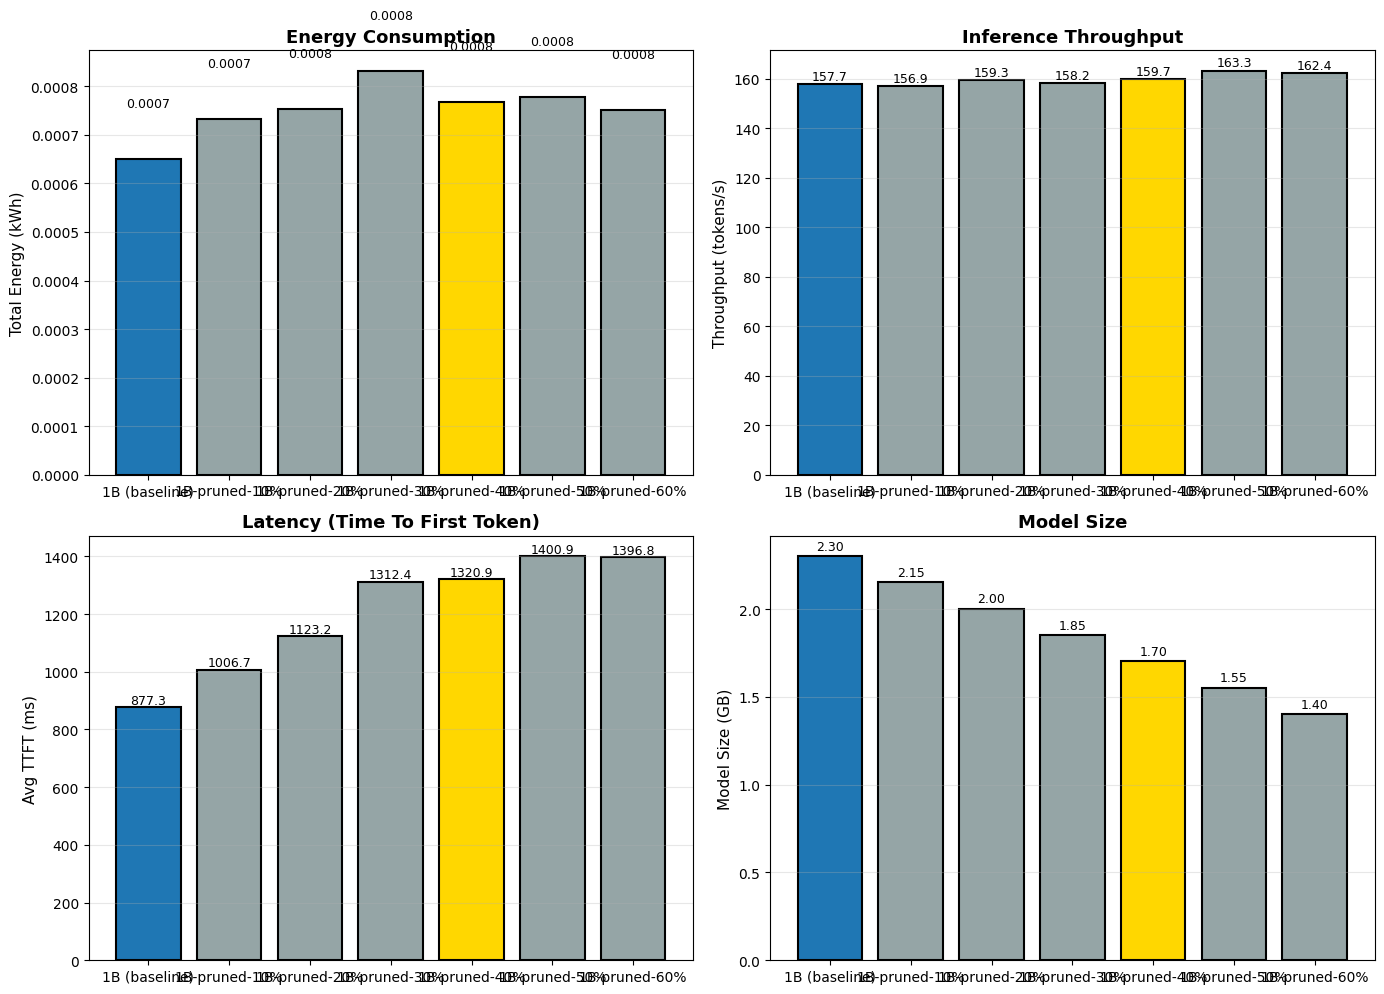


📊 Visualization saved to: /content/drive/MyDrive/glu_pruning/results/carbon_1b_analysis.png


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = summary_df['model'].values
pruning_levels = summary_df['pruning_pct'].values
star_mask = summary_df['is_star'].values

# Colors: baseline blue, star gold, others gray
colors = ['#1f77b4' if p == 0 else '#FFD700' if s else '#95a5a6'
          for p, s in zip(pruning_levels, star_mask)]

# 1. Energy Consumption
axes[0, 0].bar(range(len(models)), summary_df['total_energy_kwh'], color=colors, edgecolor='black', linewidth=1.5)
axes[0, 0].set_xticks(range(len(models)))
axes[0, 0].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[0, 0].set_ylabel('Total Energy (kWh)', fontsize=11)
axes[0, 0].set_title('Energy Consumption', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['total_energy_kwh']):
    axes[0, 0].text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# 2. Throughput
axes[0, 1].bar(range(len(models)), summary_df['avg_throughput_tok_s'], color=colors, edgecolor='black', linewidth=1.5)
axes[0, 1].set_xticks(range(len(models)))
axes[0, 1].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[0, 1].set_ylabel('Throughput (tokens/s)', fontsize=11)
axes[0, 1].set_title('Inference Throughput', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['avg_throughput_tok_s']):
    axes[0, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# 3. Latency (TTFT)
axes[1, 0].bar(range(len(models)), summary_df['avg_ttft_ms'], color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xticks(range(len(models)))
axes[1, 0].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[1, 0].set_ylabel('Avg TTFT (ms)', fontsize=11)
axes[1, 0].set_title('Latency (Time To First Token)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['avg_ttft_ms']):
    axes[1, 0].text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# 4. Model Size
axes[1, 1].bar(range(len(models)), summary_df['model_size_gb'], color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xticks(range(len(models)))
axes[1, 1].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[1, 1].set_ylabel('Model Size (GB)', fontsize=11)
axes[1, 1].set_title('Model Size', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['model_size_gb']):
    axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/carbon_1b_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Visualization saved to: {RESULTS_DIR}/carbon_1b_analysis.png")

# 7. Agregating results.

In [22]:
# NUEVO CÓDIGO PARA LA CELDA 42

import os
import json
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path

print(f"\n{'='*70}")
print("📊 CONSTRUCTING FINAL JSON FROM AGGREGATED RESULTS")
print(f"{'='*70}\n")

# --- Validar variables globales ---
# (Asegurarse de que las variables de celdas anteriores existen)

if 'RESULTS_DIR' not in globals():
    print("⚠️ Warning: RESULTS_DIR not set. Using default './results'")
    RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"

if 'BENCHMARKS_CARBON' not in globals():
    print("❌ Error: BENCHMARKS_CARBON not defined. Recargando fallback.")
    BENCHMARKS_CARBON = [
        {"name": "gsm8k_latency_b1", "num_prompts": 10, "max_new_tokens": 100, "dataset": "gsm8k", "subset": "test", "description": "Math reasoning (Latency, TTFT, bsz=1)", "batch_size": 1},
        {"name": "mmlu_latency_b1", "num_prompts": 10, "max_new_tokens": 50, "dataset": "mmlu", "subset": "test", "description": "Knowledge QA (Latency, TTFT, bsz=1)", "batch_size": 1},
        {"name": "ifeval_latency_b1", "num_prompts": 10, "max_new_tokens": 150, "dataset": "IFEval", "subset": "train", "description": "Instruction (Latency, TTFT, bsz=1)", "batch_size": 1},
        {"name": "gsm8k_throughput_b8", "num_prompts": 10, "max_new_tokens": 100, "dataset": "gsm8k", "subset": "test", "description": "Math reasoning (Throughput, bsz=8)", "batch_size": 8},
        {"name": "mmlu_throughput_b8", "num_prompts": 10, "max_new_tokens": 50, "dataset": "mmlu", "subset": "test", "description": "Knowledge QA (Throughput, bsz=8)", "batch_size": 8},
        {"name": "ifeval_throughput_b8", "num_prompts": 10, "max_new_tokens": 150, "dataset": "IFEval", "subset": "train", "description": "Instruction (Throughput, bsz=8)", "batch_size": 8},
    ]

# --- Usar resultados ya agregados y filtrados ---
if 'aggregated_results' not in globals() or 'all_results' not in globals():
    print("❌ FATAL ERROR: 'aggregated_results' o 'all_results' no están definidos.")
    print("   Por favor, ejecute de nuevo las celdas 38 y 39 antes de esta.")
else:
    print(f"Usando 'aggregated_results' (calculados en Celda 39) para {len(aggregated_results)} modelos.")

    # --- Construir el JSON Completo ---

    # 1. Construir mapeo de configuración
    config_map = {}
    model_family_name = "Llama-3.2-1B"

    for cfg in EXPERIMENT_CONFIG_CARBON:
        if model_family_name not in cfg["base_model"]:
            continue

        pruning_pct = cfg['pruning_pct']
        # La clave debe coincidir con la usada en 'aggregated_results' (p.ej. 'baseline', '20pct', '40pct')
        key = "baseline" if pruning_pct == 0 else f"{pruning_pct}pct"
        model_name_cfg = f"{model_family_name}" if pruning_pct == 0 else f"{model_family_name}-pruned-{pruning_pct}%"

        hf_repo = cfg.get("hf_repo_id", cfg["base_model"]) if pruning_pct > 0 else cfg["base_model"]

        config_map[key] = {
            "name": model_name_cfg,
            "pruning_pct": int(pruning_pct),
            "is_star": bool(cfg["is_star"]),
            "hf_repo": hf_repo,
        }

    print(f"\nDynamically built config map for {len(config_map)} models.")

    # 2. Construir 'models_evaluated'
    models_evaluated = {}
    summary_stats_list = []

    for model_key, workload_results in aggregated_results.items():
        if model_key in config_map:
            config = config_map[model_key]

            # Usar los resultados de workload_results (ya filtrados por outliers)
            models_evaluated[model_key] = {
                "name": config["name"],
                "pruning_pct": config["pruning_pct"],
                "is_star": config["is_star"],
                "hf_repo": config["hf_repo"],
                "results": workload_results
            }

            # Calcular estadísticas de resumen (basado en Celda 40)
            valid_workloads = [w for w in workload_results.values() if 'error' not in w]
            if valid_workloads:
                joules_per_token_values = [m['joules_per_token_mean'] for m in valid_workloads if m.get('joules_per_token_mean') is not None]
                avg_joules_per_token = float(np.mean(joules_per_token_values)) if joules_per_token_values else 0.0
                ttft_values = [m['ttft_mean'] for m in valid_workloads if m.get('ttft_mean') is not None]
                avg_ttft = float(np.mean(ttft_values)) if ttft_values else 0.0

                summary_stats_list.append({
                    "model": config["name"],
                    "pruning_pct": config["pruning_pct"],
                    "is_star": config["is_star"],
                    "total_energy_kwh": sum(m.get('energy_kwh_mean', 0) for m in valid_workloads),
                    "avg_throughput_tok_s": np.mean([m.get('throughput_mean', 0) for m in valid_workloads]),
                    "avg_joules_per_token": avg_joules_per_token,
                    "avg_ttft_ms": avg_ttft,
                    "model_size_gb": list(valid_workloads)[0].get('model_size_gb', 0)
                })
        else:
            print(f"⚠️ Warning: No config map entry found for key '{model_key}'.")

    # 3. Construir 'summary_statistics'
    baseline_stats = next((s for s in summary_stats_list if s['pruning_pct'] == 0), None)
    pruned_stats = sorted([s for s in summary_stats_list if s['pruning_pct'] > 0], key=lambda x: x['pruning_pct'])

    summary_statistics = {
        "baseline": baseline_stats,
        "pruned_models": pruned_stats
    }

    # 4. Obtener hardware_info (del primer run del baseline, usando 'all_results')
    hardware_info = {}
    try:
        # 1. CORRECCIÓN: Usar la clave correcta 'run_1' (generada en la Celda 9)
        run_key_to_check = "run_1"

        if "baseline" in all_results and run_key_to_check in all_results["baseline"]:
            # 2. Obtener la metadata del primer run/workload como fuente
            first_workload_data = list(all_results["baseline"][run_key_to_check].values())[0]

            if "hardware_metadata" in first_workload_data:
                hw_meta = first_workload_data["hardware_metadata"]

                # 3. CONSTRUCCIÓN CURADA: Crear el diccionario limpio que especificaste
                hardware_info = {
                    "gpu_model": hw_meta.get("gpu_name_torch"),
                    "gpu_memory_gb": round(hw_meta.get("gpu_total_memory_gb", 0), 2),
                    "gpu_compute_capability": hw_meta.get("gpu_compute_capability"),
                    "cuda_version": hw_meta.get("cuda_version"),
                    "torch_version": hw_meta.get("torch_version"),
                    "gpu_temperature_celsius": hw_meta.get("gpu_temperature_celsius"),
                }

                # 4. AÑADIR DATOS DE IDLE: Obtener de la variable global 'idle_calibration' (de la Celda 8)
                if 'idle_calibration' in globals():
                    hardware_info["idle_power_watts"] = round(idle_calibration.get("idle_power_watts", 0), 2)
                    hardware_info["idle_power_measurement_duration_sec"] = idle_calibration.get("duration_seconds")
                    hardware_info["idle_power_measurement_timestamp"] = idle_calibration.get("timestamp")
                else:
                    print("    Warning: 'idle_calibration' no encontrada. Faltarán datos de idle power.")

                print(f"    Successfully captured and curated hardware metadata (GPU: {hardware_info.get('gpu_model', 'N/A')})")
            else:
                print("    'hardware_metadata' not found in first workload.")
        else:
            print(f"    Could not find '{run_key_to_check}' in 'all_results[\"baseline\"]'. Keys available: {list(all_results.get('baseline', {}).keys())}")

    except Exception as e:
        print(f"    Error extracting hardware info: {e}")
        import traceback
        traceback.print_exc()


    # 5. Consolidar todo
    complete_results = {
        "experiment_metadata": {
            "timestamp": datetime.now().isoformat(),
            "notebook": "03_Evaluate_1B_CARBON.ipynb",
            "model_family": model_family_name,
            "pruning_method": "MAW (Maximum Absolute Weight)",
            "hardware_details": hardware_info
        },
        "benchmarks": [
            {
                "name": task["name"],
                "num_prompts": task["num_prompts"],
                "max_new_tokens": task["max_new_tokens"],
                "description": task["description"]
            }
            for task in BENCHMARKS_CARBON
        ],
        "models_evaluated": models_evaluated,
        "summary_statistics": summary_statistics,
        "citation": {
            "paper": "Exploring GLU Expansion Ratios: Structured Pruning in Llama-3.2 Models",
            "author": "Pere Martra",
            "doi": "https://doi.org/10.31219/osf.io/qgxea",
            "github": "https://github.com/peremartra/llama-glu-expansion-pruning",
            "note": "Results are freely available for research purposes. Please cite the paper if you use this data."
        }
    }
    print(f"\nSuccessfully consolidated results for {len(models_evaluated)} models.")

    # --- Guardar en JSON ---
    try:
        os.makedirs(RESULTS_DIR, exist_ok=True)

        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        json_path = f"{RESULTS_DIR}/llama_1b_carbon_complete_results_{timestamp}.json"
        with open(json_path, 'w') as f:
            json.dump(complete_results, f, indent=2, ensure_ascii=False, default=str)

        print(f"\n✅ Complete (and filtered) carbon results saved to:")
        print(f"   {json_path}")

        latest_json = f"{RESULTS_DIR}/llama_1b_carbon_complete_results_latest.json"
        with open(latest_json, 'w') as f:
            json.dump(complete_results, f, indent=2, ensure_ascii=False, default=str)

        print(f"✅ Latest (and filtered) version:")
        print(f"   {latest_json}")

        file_size_kb = Path(json_path).stat().st_size / 1024
        print(f"\n📊 File size: {file_size_kb:.1f} KB")

    except Exception as e:
        print(f"❌ Error saving JSON files: {e}")

    print(f"\n{'='*70}")
    print("✅ COMPLETE CARBON RESULTS SAVED - Ready for research sharing")
    print(f"{'='*70}\n")


📊 CONSTRUCTING FINAL JSON FROM AGGREGATED RESULTS

Usando 'aggregated_results' (calculados en Celda 39) para 7 modelos.

Dynamically built config map for 7 models.
    Successfully captured and curated hardware metadata (GPU: NVIDIA L4)

Successfully consolidated results for 7 models.

✅ Complete (and filtered) carbon results saved to:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_carbon_complete_results_20251107_134516.json
✅ Latest (and filtered) version:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_carbon_complete_results_latest.json

📊 File size: 114.4 KB

✅ COMPLETE CARBON RESULTS SAVED - Ready for research sharing



---

## 🎓 Key Takeaways

This notebook evaluated the Llama-3.2-1B model family across different datasets to determine:

1. **Optimal pruning level** for GLU-MLP layers
2. **Performance-Carbon emission trade-offs** at different expansion ratios


---

**Powered by [OptiPFair](https://github.com/peremartra/optipfair)** - Structured Pruning for GLU Architectures

If this research helps your work:
- ⭐ Star [the repo](https://github.com/peremartra/optipfair)
- 📖 Read the [documentation](https://peremartra.github.io/optipfair/)
- 🐛 Report issues or suggest features

---